<a href="https://colab.research.google.com/github/olivier2106/SP/blob/master/backtest_9_1(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## backtest_9.1 : 
1. impact estimates included

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
import datetime 
from datetime import timedelta
%matplotlib inline
import glob
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn import linear_model
from scipy.special import erf
import math
import itertools
from sklearn import preprocessing
from functools import reduce 

In [2]:
!pip install pyfolio


     |████████████████████████████████| 92kB 3.2MB/s 
     |████████████████████████████████| 51kB 20.8MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp36-none-any.whl size=88668 sha256=ef9bc8043bfd4e2fcece055b937451de5fbc97f5a47c9028bfff22bf9b076229
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.3-cp36-none-any.whl size=37089 sha256=1464ff6b7767993a45e7354c6195fcfd70b11de9adff76a9ed2744182a1211c7
  Stored in directory: /root/.cache/pip/wheels/10/a4/3b/951bd609878a82fd72b9ea23699daf1eaada4ff6f583152876
Successfully built pyfolio empyrical


In [0]:
#functions 
def remove_unnamed_cols(df):
    df=df[[col for col in df.columns if 'Unnamed:' not in col]]
    return df

def make_date_index(df):
    df['Date']=pd.to_datetime(df['Date']).dt.date
    df=df.set_index('Date')
    return df

def intersection(a,b):
    inter=list(set(a)&set(b))
    return inter

def momentum(temp, window):
    temp=temp.fillna(1)
    temp=pd.rolling_apply(temp, window, lambda x: np.prod(x))
    return temp

def winner_takes_all(raven_copydf, rel, highS, lowS, start_date, end_date, start_window, end_window):
    raven_copydf['Timestamp']=pd.to_datetime(raven_copydf['Timestamp'])
    raven_copydf['time']=raven_copydf['Timestamp'].dt.time
    raven_copydf=raven_copydf[raven_copydf['time']>=start_window]
    raven_copydf=raven_copydf[raven_copydf['time']<=end_window]
    raven_copy2df=raven_copydf[raven_copydf['relevance']>=rel]
    raven_copy2df['Max_sent']=raven_copy2df[['sentimentNegative', 'sentimentNeutral','sentimentPositive']].max(axis=1)
    #test['test']=test[test['sentimentNegative']>=test['Max_sent']]
    raven_copy2df['Neg'] = np.where(raven_copy2df['sentimentNegative']==raven_copy2df['Max_sent'], -1, 0)
    raven_copy2df['Pos'] = np.where(raven_copy2df['sentimentPositive']==raven_copy2df['Max_sent'], 1, 0)
    raven_copy2df['Neu'] = np.where(raven_copy2df['sentimentNeutral']==raven_copy2df['Max_sent'], 0, 0)
    raven_copy2df['Signal']=raven_copy2df['Neg']+raven_copy2df['Pos'] +raven_copy2df['Neu']
    raven_copy2df['EVENT_SENTIMENT_SCORE']=raven_copy2df['Signal']*raven_copy2df['Max_sent']

    raven_copy2df['day']=pd.to_datetime(raven_copy2df['day']).dt.date

    raven_copy2df=raven_copy2df[raven_copy2df['day']>=start_date]
    raven_copy2df=raven_copy2df[raven_copy2df['day']<=end_date]

    
    raven_copy3df=raven_copy2df[(raven_copy2df['EVENT_SENTIMENT_SCORE']<=lowS)] 
    raven_copy4df= raven_copy2df[(raven_copy2df['EVENT_SENTIMENT_SCORE']>=highS)]

    frames=[raven_copy3df, raven_copy4df]
    raven_copy2df=pd.concat(frames)
    raven_copy2df['Date']=raven_copy2df['Timestamp']
    raven_copy2df=raven_copy2df.sort('Date') 
  
    return raven_copy2df

def weighted_ave_sentiment(raven_reldf, start, end):
    tempdf=raven_reldf[raven_reldf['relevance']>=start] 
    tempdf=tempdf[tempdf['relevance']<=end]
    tempdf['wt']=abs(tempdf['EVENT_SENTIMENT_SCORE'])
    tempdf['weight'] = tempdf['wt'] / tempdf.groupby(['Ticker', 'day'])['wt'].transform('sum')
    tempdf['EVENT_SENTIMENT_SCORE'] = tempdf['weight']*tempdf['EVENT_SENTIMENT_SCORE']
    g1=tempdf.groupby(['Ticker', 'day'])['EVENT_SENTIMENT_SCORE'].sum()

    g1=g1.reset_index()
    g1=g1.sort(['day'])
    g1['day'] = pd.to_datetime(g1['day'], coerce=True)
    g1['weekday']=g1['day'].dt.dayofweek
    g1=g1[g1['weekday']<5]
    pivotdf=g1.pivot(index='day', columns='Ticker', values='EVENT_SENTIMENT_SCORE')
    pivotdf=pivotdf.reset_index()

    signalsdf=pivotdf.fillna(0)
    #pivotdf=pivotdf.set_index('day')
    tempdf=pivotdf.set_index('day')
    sentimentdf=signalsdf.set_index('day')
    return sentimentdf, g1

def total_traded_open(opendf, volume, fx_histdf, fxdf):
    op_px=opendf.copy()
    op_vol=volume.copy()
    fxhist=fx_histdf.copy()
    fx=fxdf.copy()
    # british stocks are given in pence
    cols=[col for col in op_px.columns if 'LN Equity' in col]
    op_px[cols]=op_px[cols]*0.01

    cols=fxhist.columns.values
    i=0
    for col in cols:
        col=col.split()[0]
        cols[i]=col[3:]
        i=i+1
    fxhist.columns=cols
    fxhist['EUR']=1

    fxhist=fxhist.divide(fxhist['GBP'], axis="index")

    tictoCRNCY=fx[['Ex', 'CRNCY']]
    tictoCRNCY=tictoCRNCY.replace({'GBp': 'GBP'}, regex=True)
    tCdict=tictoCRNCY.set_index('Ex').to_dict()
    tCdict['CRNCY']['SM']='EUR'
    tCdict['CRNCY']['GR']='EUR'
    for col in op_px.columns:

        op_px[col]=op_px[col]*fxhist[tCdict['CRNCY'][col.split(' ')[1]]]

    tot_op_px=op_px*op_vol
    return tot_op_px, op_vol, op_px

#new functions 
def unstack(df, columns):
    vec=df.unstack().reset_index()
    vec.columns=columns
    vec=vec.sort('day')
    return vec


#this will be the standard rolling regression from now on
def rolling_lin_reg(df, window, features):
    dates=df['day'].unique().tolist()
    #pred=np.array()
    #print('start rolling lin reg')
    for i in range(len(dates)):
        #print(i)
        if (i <= window) & (i==0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            pred=np.tile(np.nan, size)
            day=np.tile(dates[i], size)
            #print(size)
        elif (i<= window) & (i!=0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            pred = np.append(pred, np.tile(np.nan, size))
            day=np.append(day,np.tile(dates[i], size))           
        else:
            model = linear_model.Ridge(alpha=0.8)
            temp=df[df['day']<dates[i]]
            temp=temp[temp['day']>=dates[i-window]]
            X_train=temp[features]
            Y_train=temp['ret']
            test=df[df['day']==dates[i]]
            size=test.shape[0]
            X_test=test[features]
            model.fit(X_train, Y_train)
            pred = np.append(pred, model.predict(X_test))  
            day=np.append(day,np.tile(dates[i], size))
    df['pred']=pred
    #df['day_comop']=day
    return df    

def scale_weights(df, min_factor, max_factor):
    to_be_scaled='weights'
    dates=df['day'].unique().tolist()
    dfs=[]
    for day in dates:
        print(day)
        
        tempdf=df[df['day']==day]
        mn=tempdf[to_be_scaled].min()
        tempdf[to_be_scaled]=tempdf[to_be_scaled]-mn
        m=(max_factor-min_factor)/(tempdf[to_be_scaled].max()-tempdf[to_be_scaled].min())
        c=min_factor
        tempdf['scaled_weights']=tempdf[to_be_scaled]*m+c
        dfs.append(tempdf)
    return pd.concat(dfs)

def regression_weights(weights_params, weights_format, factors_list, window, zscore_win, minmult, maxmult):
    pred_df=rolling_lin_reg(weights_params, window, factors_list)
    print('regression: complete')
    pred_df['weights_metric']=pred_df['sign']*pred_df['pred'] # +*+ and -*- will have high z scores +*- low z scores
    tmppdf=pred_df.dropna()
    tmppdf['z_score']=(tmppdf['weights_metric']-tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).mean())/(tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).std())
    #tmppdf['weights']=(tmppdf['weights_metric']-tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).mean())/(tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).std())
    
    print('z-scores: complete')
    tmppdf['weights']=0.5*(1+erf(tmppdf['z_score'])/math.sqrt(2))
    weights_vec=scale_weights(tmppdf, minmult, maxmult)   
    print('scaling: complete')
    weights=weights_vec.copy()
    weights=weights.pivot(values='scaled_weights', columns='Ticker', index='day')
    weights=weights*weights_format
    weights=weights.fillna(1)
    weights.index.name='Date'
    return weights


def regression_weights2(weights_params, weights_format, factors_list, window, zscore_win, minmult, maxmult):
    print('start regression')
    pred_df=rolling_lin_reg(weights_params, window, factors_list)
    print('regression: complete')
    pred_df['weights_metric']=pred_df['sign']*pred_df['pred'] # +*+ and -*- will have high z scores +*- low z scores
    tmppdf=pred_df.dropna()
    #tmppdf['z_score']=(tmppdf['weights_metric']-tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).mean())/(tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).std())
    meandf=tmppdf.groupby('day')['weights_metric'].mean().reset_index()
    meandf=meandf.rename(columns={'weights_metric':'mean'})
    tmppdf=pd.merge(meandf, tmppdf, on='day')
    stddf=tmppdf.groupby('day')['weights_metric'].std().reset_index()
    stddf=stddf.rename(columns={'weights_metric':'std'})
    tmppdf=pd.merge(stddf, tmppdf, on='day')
    tmppdf['z_score']=(tmppdf['weights_metric']-tmppdf['mean'])/tmppdf['std']
    #tmppdf['weights']=(tmppdf['weights_metric']-tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).mean())/(tmppdf['weights_metric'].rolling(zscore_win, min_periods=1).std())
    
    print('z-scores: complete')
    tmppdf['weights']=0.5*(1+erf(tmppdf['z_score'])/math.sqrt(2))
    weights_vec=scale_weights(tmppdf, minmult, maxmult)   
    print('scaling: complete')
    weights=weights_vec.copy()
    weights=weights.pivot(values='scaled_weights', columns='Ticker', index='day')
    weights=weights*weights_format
    weights=weights.fillna(1)
    weights.index.name='Date'
    return weights

def JUMP_constraint(c2o, signalsdf, level):
    
    temp=c2o.copy()

    temp=(temp-1)*100

    temp[temp>=level]=0
    temp[temp<=-level]=0

    temp=temp.fillna(0)
    temp[temp!=0]=1
    temp[temp==0]=np.nan
    #temp=temp[cols]

    tempdf=signalsdf*temp
    tempdf=tempdf.dropna(how='all', axis=0)
    return tempdf


def weighted_constrained(nominal, nominal_high, posmult, negmult, weights, tot_traded_fx, pc_of_liq, signalsdf, OtoCdf, indexdf):

    tot_opendf=tot_traded_fx.copy()
    tot_vec=tot_opendf.unstack().reset_index()
    tot_vec.columns=[['Ticker','Date', 'Total']]
    g1=tot_vec.groupby('Ticker')['Total'].mean().reset_index()

    g1=g1.sort('Total')
    g1=g1.reset_index()
    a=g1.index.tolist()
    top250=g1[350:]['Ticker'].tolist()
    bottom350=g1[:350]['Ticker'].tolist()

    maxdf=tot_opendf*pc_of_liq
    signalsdf[signalsdf>0]=1
    signalsdf[signalsdf<0]=-1
    maxtradeabledf=signalsdf*maxdf
    maxtradeabledf=maxtradeabledf.fillna(0)
    lmaxtradeabledf=maxtradeabledf[maxtradeabledf>0].fillna(0)
    smaxtradeabledf=maxtradeabledf[maxtradeabledf<0].fillna(0)
    tempdf=maxtradeabledf.copy()

    countdf=pd.DataFrame()

    countdf['Count_Pos']=(signalsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Count_Neg']=(signalsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['total_count']=countdf['Count_Pos']+countdf['Count_Neg']
    countdf['long_fixed']=nominal*posmult
    countdf['short_fixed']=nominal*negmult
    countdf['high_long_fixed']=nominal_high*posmult
    countdf['high_short_fixed']=nominal_high*negmult

    tempdf[tempdf>0]=1
    tempdf[tempdf<0]=-1
    longsignalsdf=tempdf[tempdf>=0].fillna(0)
    shortsignalsdf=tempdf[tempdf<=0].fillna(0)


    templongsignalsdf=longsignalsdf[bottom350]
    tempshortsignalsdf=shortsignalsdf[bottom350]
    lowlongsignalsdf=templongsignalsdf.multiply(countdf['long_fixed'], axis="index")
    lowshortsignalsdf=tempshortsignalsdf.multiply(countdf['short_fixed'], axis="index")

    templongsignalsdf=longsignalsdf[top250]
    tempshortsignalsdf=shortsignalsdf[top250]
    highlongsignalsdf=templongsignalsdf.multiply(countdf['high_long_fixed'], axis="index")
    highshortsignalsdf=tempshortsignalsdf.multiply(countdf['high_short_fixed'], axis="index")

    longsignalsdf=pd.merge(highlongsignalsdf, lowlongsignalsdf, left_index=True,right_index=True).fillna(0)
    shortsignalsdf=pd.merge(highshortsignalsdf, lowshortsignalsdf, left_index=True,right_index=True).fillna(0)
    


    longsignalsdf=longsignalsdf*weights
    shortsignalsdf=shortsignalsdf*weights
    
    
    cols=lmaxtradeabledf.columns.tolist()
    longsignalsdf=longsignalsdf[cols].fillna(0)
    shortsignalsdf=shortsignalsdf[cols].fillna(0)

    #Alternatively () instead of uncommented used this (similarily for shorts)
    longsignalsdf=longsignalsdf.where(longsignalsdf<lmaxtradeabledf, lmaxtradeabledf).fillna(longsignalsdf)

    #make caps shorts
    shortsignalsdf=shortsignalsdf.where(shortsignalsdf>smaxtradeabledf, smaxtradeabledf).fillna(shortsignalsdf)

    longcash=longsignalsdf.copy()
    shortcash=shortsignalsdf.copy()
    long=longsignalsdf.copy()
    short=shortsignalsdf.copy()
    
    ###new
    long[long>0]=1
    short[short<0]=1
    long=OtoCdf*long
    short=OtoCdf*short
    
    #####new signal formatting
    formatret=(OtoCdf/OtoCdf).fillna(0)

    longsignalsdf=longsignalsdf*formatret
    shortsignalsdf=shortsignalsdf*formatret
    ########################
    longreturnsdf=OtoCdf*longsignalsdf
    shortreturnsdf=OtoCdf*shortsignalsdf
    l_close=OtoCdf*longsignalsdf.copy()
    s_close=OtoCdf*shortsignalsdf.copy()
    l_open=longsignalsdf.copy()
    s_open=shortsignalsdf.copy()

    shortreturnsdf=shortreturnsdf.fillna(0)
    longreturnsdf=longreturnsdf.fillna(0)

    countdf['Constrained_Count_Pos']=(longreturnsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Constrained_Count_Neg']=(shortreturnsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['Constrained_total_count']=countdf['Constrained_Count_Pos']+countdf['Constrained_Count_Neg']

    portfolio=pd.DataFrame()
    portfolio['long_Day_end']=longreturnsdf.sum(axis=1)
    portfolio['short_Day_end']=shortreturnsdf.sum(axis=1)
    portfolio['long_Day_start']=longsignalsdf.sum(axis=1)
    portfolio['short_Day_start']=shortsignalsdf.sum(axis=1)

    portfolio['Diff_long']=portfolio['long_Day_end']-portfolio['long_Day_start']
    portfolio['Diff_short']=portfolio['short_Day_end']-portfolio['short_Day_start']
    portfolio['raw_profit']=portfolio['Diff_long']+portfolio['Diff_short']
    portfolio['acc_raw_profit']=portfolio['raw_profit'].cumsum()

    #copydf=indexdf[['day','SXXP Index']]
    #countdf=countdf.reset_index()
    #countdf['day']=countdf['Date']
    #countdf['day']=countdf['day'].dt.date
    #countdf=pd.merge(countdf, copydf, on='day', how='left')
    portfolio=portfolio.reset_index()
    portfolio['Date']=pd.to_datetime(portfolio['Date'])
    portfolio['Date']=portfolio['Date'].dt.date
    portfolio['day']=portfolio['Date']
    copydf=indexdf[['day','SXXP Index']]
    portfolio=pd.merge(portfolio, copydf, on='day', how='left')
    portfolio['tot_invested']=-portfolio['short_Day_start']+portfolio['long_Day_start']
    portfolio['delta_Day_start']=-(portfolio['short_Day_start']+portfolio['long_Day_start'])
    portfolio['tot_invested_plus_hedge']=portfolio['tot_invested']+abs(portfolio['delta_Day_start'])
    portfolio['delta_Day_end']=portfolio['delta_Day_start']*(portfolio['SXXP Index']+1)
    portfolio['diff_hedge']=portfolio['delta_Day_end']-portfolio['delta_Day_start']
    portfolio['raw_profit_hedged']=portfolio['raw_profit']+portfolio['diff_hedge']
    portfolio['acc_raw_profit_hedged']=portfolio['raw_profit_hedged'].cumsum()
    portfolio['hedge_ret']=portfolio['raw_profit_hedged']/portfolio['tot_invested_plus_hedge']

    del portfolio['SXXP Index']
    del portfolio['day']
    portfolio=portfolio.set_index('Date')

    countdf=countdf.reset_index()
    portfolio=portfolio.reset_index()
    countdf['Date']=countdf['Date'].dt.date
    #portfolio['Date']=portfolio['Date'].dt.date
    allinfodf=pd.merge(countdf, portfolio, on='Date')
    allinfodf['returns']=(allinfodf['Diff_short']+allinfodf['Diff_long'])/(allinfodf['tot_invested'])
    #allinfodf['ret_per_trade']=((allinfodf['Diff_short']+allinfodf['Diff_long'])/allinfodf['total_count'])/(nominal)+1
    allinfodf['ret_per_short_trade']=(allinfodf['Diff_short']/allinfodf['Count_Neg'])/nominal+1
    allinfodf['ret_per_long_trade']=(allinfodf['Diff_long']/allinfodf['Count_Pos'])/nominal+1
    allinfodf['day']=allinfodf['Date']
    copydf=indexdf[['day','SXXP Index']]
    allinfodf=pd.merge(allinfodf, copydf, on='day', how='left')
    allinfodf['returns_detrend']=allinfodf['returns']-allinfodf['SXXP Index']
    allinfodf['ratio_pos_neg']=(allinfodf['Count_Pos']+1)/(allinfodf['Count_Neg']+1)
    return allinfodf, l_open, s_open, l_close, s_close

def subjects_data(df):
    subjectsdf=df[['subjects', 'Ticker']]
    
    subjectsdf=subjectsdf.reset_index()
    subjectsdf['subjects']=subjectsdf['subjects'].apply(lambda x:x.split(' '))
    subjectsdf['Date']=pd.to_datetime(subjectsdf['Date']).dt.date
    subjectsdf2=subjectsdf.groupby(['Ticker', 'Date'])['subjects'].apply(list).reset_index()
    subjectsdf2['Date']=pd.to_datetime(subjectsdf2['Date']).dt.date
    subjectsdf2['number_articles']=subjectsdf2['subjects'].apply(lambda x:len(x) )
    
    subjectsdf2['subjects']=subjectsdf2['subjects'].apply(lambda x:list(itertools.chain.from_iterable(x)))
    subjects_listdf=subjectsdf2.pivot(values='subjects', index='Date', columns='Ticker')
    subjects_countdf=subjectsdf2.pivot(values='number_articles', index='Date', columns='Ticker')
    return subjects_listdf, subjects_countdf

def exclude_subject_df(subs, sent_index, subjectsdf):
    temp=subjectsdf.copy()
    temp=temp.unstack().reset_index()
    temp.columns=['Ticker', 'Date', 'subjects']

    temp=temp.dropna()

    temp['topic']=temp['subjects'].apply(lambda x: len(list(set(x) & set(subs))))
    temp['topic'][temp['topic']>0]=1

    temp=temp.pivot(values='topic', index='Date', columns='Ticker')
    temp=temp[temp.index.isin(sent_index)]
    temp[temp==0]=np.nan
    temp[temp==1]=0
    temp=temp.fillna(1)
    return temp

def weighted_constrained(nominal, nominal_high, posmult, negmult, weights, tot_traded_fx, pc_of_liq, signalsdf, o2c, indexdf):

    tot_opendf=tot_traded_fx.copy()
    tot_vec=tot_opendf.unstack().reset_index()
    tot_vec.columns=[['Ticker','Date', 'Total']]
    g1=tot_vec.groupby('Ticker')['Total'].mean().reset_index()

    g1=g1.sort('Total')
    g1=g1.reset_index()
    a=g1.index.tolist()
    top250=g1[350:]['Ticker'].tolist()
    bottom350=g1[:350]['Ticker'].tolist()

    maxdf=tot_opendf*pc_of_liq
    signalsdf[signalsdf>0]=1
    signalsdf[signalsdf<0]=-1
    maxtradeabledf=signalsdf*maxdf
    maxtradeabledf=maxtradeabledf.fillna(0)
    lmaxtradeabledf=maxtradeabledf[maxtradeabledf>0].fillna(0)
    smaxtradeabledf=maxtradeabledf[maxtradeabledf<0].fillna(0)
    tempdf=maxtradeabledf.copy()

    countdf=pd.DataFrame()

    countdf['Count_Pos']=(signalsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Count_Neg']=(signalsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['total_count']=countdf['Count_Pos']+countdf['Count_Neg']
    countdf['long_fixed']=nominal*posmult
    countdf['short_fixed']=nominal*negmult
    countdf['high_long_fixed']=nominal_high*posmult
    countdf['high_short_fixed']=nominal_high*negmult

    tempdf[tempdf>0]=1
    tempdf[tempdf<0]=-1
    longsignalsdf=tempdf[tempdf>=0].fillna(0)
    shortsignalsdf=tempdf[tempdf<=0].fillna(0)


    templongsignalsdf=longsignalsdf[bottom350]
    tempshortsignalsdf=shortsignalsdf[bottom350]
    lowlongsignalsdf=templongsignalsdf.multiply(countdf['long_fixed'], axis="index")
    lowshortsignalsdf=tempshortsignalsdf.multiply(countdf['short_fixed'], axis="index")

    templongsignalsdf=longsignalsdf[top250]
    tempshortsignalsdf=shortsignalsdf[top250]
    highlongsignalsdf=templongsignalsdf.multiply(countdf['high_long_fixed'], axis="index")
    highshortsignalsdf=tempshortsignalsdf.multiply(countdf['high_short_fixed'], axis="index")

    longsignalsdf=pd.merge(highlongsignalsdf, lowlongsignalsdf, left_index=True,right_index=True).fillna(0)
    shortsignalsdf=pd.merge(highshortsignalsdf, lowshortsignalsdf, left_index=True,right_index=True).fillna(0)
    


    longsignalsdf=longsignalsdf*weights
    shortsignalsdf=shortsignalsdf*weights
    
    
    cols=lmaxtradeabledf.columns.tolist()
    longsignalsdf=longsignalsdf[cols].fillna(0)
    shortsignalsdf=shortsignalsdf[cols].fillna(0)

    #Alternatively () instead of uncommented used this (similarily for shorts)
    longsignalsdf=longsignalsdf.where(longsignalsdf<lmaxtradeabledf, lmaxtradeabledf).fillna(longsignalsdf)

    #make caps shorts
    shortsignalsdf=shortsignalsdf.where(shortsignalsdf>smaxtradeabledf, smaxtradeabledf).fillna(shortsignalsdf)

    longcash=longsignalsdf.copy()
    shortcash=shortsignalsdf.copy()
    long=longsignalsdf.copy()
    short=shortsignalsdf.copy()
    
    ###new
    long[long>0]=1
    short[short<0]=1
    long=o2c*long
    short=o2c*short
    
    #####new signal formatting
    formatret=(o2c/o2c).fillna(0)

    longsignalsdf=longsignalsdf*formatret
    shortsignalsdf=shortsignalsdf*formatret
    ########################
    longreturnsdf=o2c*longsignalsdf
    shortreturnsdf=o2c*shortsignalsdf
    l_close=o2c*longsignalsdf.copy()
    s_close=o2c*shortsignalsdf.copy()
    l_open=longsignalsdf.copy()
    s_open=shortsignalsdf.copy()

    shortreturnsdf=shortreturnsdf.fillna(0)
    longreturnsdf=longreturnsdf.fillna(0)

    countdf['Constrained_Count_Pos']=(longreturnsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Constrained_Count_Neg']=(shortreturnsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['Constrained_total_count']=countdf['Constrained_Count_Pos']+countdf['Constrained_Count_Neg']

    portfolio=pd.DataFrame()
    portfolio['long_Day_end']=longreturnsdf.sum(axis=1)
    portfolio['short_Day_end']=shortreturnsdf.sum(axis=1)
    portfolio['long_Day_start']=longsignalsdf.sum(axis=1)
    portfolio['short_Day_start']=shortsignalsdf.sum(axis=1)

    portfolio['Diff_long']=portfolio['long_Day_end']-portfolio['long_Day_start']
    portfolio['Diff_short']=portfolio['short_Day_end']-portfolio['short_Day_start']
    portfolio['raw_profit']=portfolio['Diff_long']+portfolio['Diff_short']
    portfolio['acc_raw_profit']=portfolio['raw_profit'].cumsum()

    #copydf=indexdf[['day','SXXP Index']]
    #countdf=countdf.reset_index()
    #countdf['day']=countdf['Date']
    #countdf['day']=countdf['day'].dt.date
    #countdf=pd.merge(countdf, copydf, on='day', how='left')
    #portfolio=portfolio.reset_index()
    #portfolio['Date']=pd.to_datetime(portfolio['Date'])
    #portfolio['Date']=portfolio['Date'].dt.date
    #portfolio['day']=portfolio.index
    copydf=indexdf[['SXXP Index']]
    portfolio=pd.merge(portfolio, copydf, right_index=True, left_index=True, how='left')
    portfolio['tot_invested']=-portfolio['short_Day_start']+portfolio['long_Day_start']
    portfolio['delta_Day_start']=-(portfolio['short_Day_start']+portfolio['long_Day_start'])
    portfolio['tot_invested_plus_hedge']=portfolio['tot_invested']+abs(portfolio['delta_Day_start'])
    portfolio['delta_Day_end']=portfolio['delta_Day_start']*(portfolio['SXXP Index']+1)
    portfolio['diff_hedge']=portfolio['delta_Day_end']-portfolio['delta_Day_start']
    portfolio['raw_profit_hedged']=portfolio['raw_profit']+portfolio['diff_hedge']
    portfolio['acc_raw_profit_hedged']=portfolio['raw_profit_hedged'].cumsum()
    portfolio['hedge_ret']=portfolio['raw_profit_hedged']/portfolio['tot_invested_plus_hedge']

    del portfolio['SXXP Index']
    
    #portfolio=portfolio.set_index('Date')

    #countdf=countdf.reset_index()
    #portfolio=portfolio.reset_index()
    #countdf['Date']=countdf['Date'].dt.date
    #portfolio['Date']=portfolio['Date'].dt.date
    allinfodf=pd.merge(countdf, portfolio, right_index=True, left_index=True)
    allinfodf['returns']=(allinfodf['Diff_short']+allinfodf['Diff_long'])/(allinfodf['tot_invested'])
    #allinfodf['ret_per_trade']=((allinfodf['Diff_short']+allinfodf['Diff_long'])/allinfodf['total_count'])/(nominal)+1
    allinfodf['ret_per_short_trade']=(allinfodf['Diff_short']/allinfodf['Count_Neg'])/nominal+1
    allinfodf['ret_per_long_trade']=(allinfodf['Diff_long']/allinfodf['Count_Pos'])/nominal+1
    #allinfodf['day']=allinfodf['Date']
    copydf=indexdf[['SXXP Index']]
    allinfodf=pd.merge(allinfodf, copydf, right_index=True, left_index=True, how='left')
    allinfodf['returns_detrend']=allinfodf['returns']-allinfodf['SXXP Index']
    allinfodf['ratio_pos_neg']=(allinfodf['Count_Pos']+1)/(allinfodf['Count_Neg']+1)
    return allinfodf, l_open, s_open, l_close, s_close

def groups_per_day(df, splits):
    df = df.dropna(how='all', axis=0)
    df_index=df.index.tolist()

    temp=df.unstack().reset_index()
    temp.columns=['Ticker', 'Date', 'voi']
    groups_app=[]
    for i in df_index:
        sub_temp=temp[temp['Date']==i]
        sub_temp['group']=pd.qcut(sub_temp['voi'], splits, labels=False)
        groups_app.append(sub_temp)
        print(i)
    voi_temp=pd.concat(groups_app)
    voi_group=voi_temp.pivot(values='group', columns='Ticker', index='Date')
    voi_group=voi_group+1
    return voi_group

def size_vol_groups_format(vol_group_splits, size_group_splits):
    s_v_format_plus=[]
    s_v_format_minus=[]
    for v_split in range(vol_group_splits):
        for s_split in range(size_group_splits):
            s_v_format_plus.append((v_split+1,s_split+1))
            s_v_format_minus.append((-1*(v_split+1),s_split+1))

    sv_plusdf=pd.DataFrame(s_v_format_plus, columns=['vol', 'size'])    
    sv_minusdf=pd.DataFrame(s_v_format_minus, columns=['vol', 'size'])
    frames=[sv_minusdf, sv_plusdf]
    s_v_format=pd.concat(frames)
    s_v_format=s_v_format.sort_values(by=['vol', 'size']).reset_index().drop('index', axis=1)
    return s_v_format

def weighted_constrained_levels(nominal, nominal_high, posmult, negmult, weights, tot_traded_fx, pos_liq_pcs, neg_liq_pcs, signalsdf, o2c, indexdf):
    tot_opendf=tot_traded_fx.copy()
    tot_vec=tot_opendf.unstack().reset_index()
    tot_vec.columns=[['Ticker','Date', 'Total']]
    g1=tot_vec.groupby('Ticker')['Total'].mean().reset_index()

    g1=g1.sort('Total')
    g1=g1.reset_index()
    a=g1.index.tolist()
    top=g1[350:]['Ticker'].tolist()
    bottom=g1[:350]['Ticker'].tolist()

    #these hold the maximum liquidity available at the different levels
    posmaxdfs=[]
    negmaxdfs=[]
    for pc in pos_liq_pcs:
        posmaxdfs.append(tot_opendf*pc)
    for pc in neg_liq_pcs:
        negmaxdfs.append(tot_opendf*pc)

    signalsdf[signalsdf>0]=1
    signalsdf[signalsdf<0]=-1

    pos_s=signalsdf[signalsdf>0]
    neg_s=signalsdf[signalsdf<0]

    pos_maxtradeabledfs=[]
    neg_maxtradeabledfs=[]
    for pmax in posmaxdfs:
        temp=(pmax*pos_s).fillna(0)
        pos_maxtradeabledfs.append(temp)
    for nmax in negmaxdfs:
        temp=(nmax*neg_s).fillna(0)
        neg_maxtradeabledfs.append(temp)


    countdf=pd.DataFrame()

    countdf['Count_Pos']=(signalsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Count_Neg']=(signalsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['total_count']=countdf['Count_Pos']+countdf['Count_Neg']
    countdf['long_fixed']=nominal*posmult
    countdf['short_fixed']=nominal*negmult
    countdf['high_long_fixed']=nominal_high*posmult
    countdf['high_short_fixed']=nominal_high*negmult

    longsignalsdfs=[]
    shortsignalsdfs=[]
    for pos_max in pos_maxtradeabledfs:
        temp=pos_max.copy()
        temp[temp>0]=1
        temp=temp.fillna(0)
        longsignalsdfs.append(temp)
    for neg_max in neg_maxtradeabledfs:
        temp=neg_max.copy()
        temp[temp<0]=-1
        temp=temp.fillna(0)
        shortsignalsdfs.append(temp)

    #now split into bucketsn for notional assignment
    lowlongsignalsdfs=[]
    lowshortsignalsdfs=[]
    for longdf in longsignalsdfs:
        templongsignalsdf=longdf[bottom]
        lowlongsignalsdf=templongsignalsdf.multiply(countdf['long_fixed'], axis="index")
        lowlongsignalsdfs.append(lowlongsignalsdf)
    for shortdf in shortsignalsdfs:    
        tempshortsignalsdf=shortdf[bottom]
        lowshortsignalsdf=tempshortsignalsdf.multiply(countdf['short_fixed'], axis="index")
        lowshortsignalsdfs.append(lowshortsignalsdf)

    highlongsignalsdfs=[]
    highshortsignalsdfs=[]
    for longdf in longsignalsdfs:
        templongsignalsdf=longdf[top]
        highlongsignalsdf=templongsignalsdf.multiply(countdf['high_long_fixed'], axis="index")
        highlongsignalsdfs.append(highlongsignalsdf)
    for shortdf in shortsignalsdfs:    
        tempshortsignalsdf=shortdf[top]
        highshortsignalsdf=tempshortsignalsdf.multiply(countdf['high_short_fixed'], axis="index")
        highshortsignalsdfs.append(highshortsignalsdf)

    highlowlongsignalsdfs=[]
    highlowshortsignalsdfs=[]
    for i in range(len(highlongsignalsdfs)):
        highlowlongsignalsdfs.append(pd.merge(highlongsignalsdfs[i], lowlongsignalsdfs[i], left_index=True,right_index=True).fillna(0))
    for i in range(len(highshortsignalsdfs)):
        highlowshortsignalsdfs.append(pd.merge(highshortsignalsdfs[i], lowshortsignalsdfs[i], left_index=True,right_index=True).fillna(0))


    long_weighted_notionaldfs=[]
    short_weighted_notionaldfs=[]
    for i in range(len(weights)):
        w=weights[i]
        long_notionals=highlowlongsignalsdfs[i]
        short_notionals=highlowshortsignalsdfs[i]
        l_n=(long_notionals*w).fillna(0)
        s_n=(short_notionals*w).fillna(0)
        long_weighted_notionaldfs.append(l_n)
        short_weighted_notionaldfs.append(s_n)

    long_notional_pcliqdfs=[]
    for i in range(len(long_weighted_notionaldfs)):
        long_notionaldf=long_weighted_notionaldfs[i]
        pmax_tradeabledf=pos_maxtradeabledfs[i]
        long_notionaldf=long_notionaldf.where(long_notionaldf<pmax_tradeabledf, pmax_tradeabledf).fillna(long_notionaldf)
        long_notional_pcliqdfs.append(long_notionaldf)

    short_notional_pcliqdfs=[]
    for i in range(len(short_weighted_notionaldfs)):
        short_notionaldf=short_weighted_notionaldfs[i]
        nmax_tradeabledf=neg_maxtradeabledfs[i]
        short_notionaldf=short_notionaldf.where(short_notionaldf>nmax_tradeabledf, nmax_tradeabledf).fillna(short_notionaldf)
        short_notional_pcliqdfs.append(short_notionaldf)

    long_open_posdfs=[]
    for l in long_notional_pcliqdfs:
        long=l.copy()
        long[long>0]=1
        long=o2c*long
        formatret=(o2c/o2c).fillna(0)
        lsig=l*formatret
        long_open_posdfs.append(lsig)

    short_open_posdfs=[]
    for s in short_notional_pcliqdfs:
        short=s.copy()
        short[short<0]=1
        short=o2c*short
        formatret=(o2c/o2c).fillna(0)
        ssig=s*formatret
        short_open_posdfs.append(ssig)

    longreturnsdfs=[]
    for long_pos in long_open_posdfs:
        longreturnsdf=o2c*long_pos
        longreturnsdf=longreturnsdf.fillna(0)
        longreturnsdfs.append(longreturnsdf)

    shortreturnsdfs=[]
    for short_pos in short_open_posdfs:
        shortreturnsdf=o2c*short_pos
        shortreturnsdf=shortreturnsdf.fillna(0)
        shortreturnsdfs.append(shortreturnsdf)

    k=0
    for long_pos in long_open_posdfs:
        if k==0:
            combo_longposdf=long_pos
        else:
            combo_longposdf=long_pos+combo_longposdf
        k=k+1

    k=0
    for short_pos in short_open_posdfs:
        if k==0:
            combo_shortposdf=short_pos
        else:
            combo_shortposdf=short_pos+combo_shortposdf
        k=k+1


    k=0
    for long_ret in longreturnsdfs:
        if k==0:
            combo_longreturnsdf=long_ret
        else:
            combo_longreturnsdf=combo_longreturnsdf+long_ret
        k=k+1

    k=0
    for short_ret in shortreturnsdfs:
        if k==0:
            combo_shortreturnsdf=short_ret
        else:
            combo_shortreturnsdf=combo_shortreturnsdf+short_ret
        k=k+1

    countdf['Constrained_Count_Pos']=(combo_longreturnsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Constrained_Count_Neg']=(combo_shortreturnsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['Constrained_total_count']=countdf['Constrained_Count_Pos']+countdf['Constrained_Count_Neg']
    portfolio=pd.DataFrame()
    portfolio['long_Day_end']=combo_longreturnsdf.sum(axis=1)
    portfolio['short_Day_end']=combo_shortreturnsdf.sum(axis=1)
    portfolio['long_Day_start']=combo_longposdf.sum(axis=1)
    portfolio['short_Day_start']=combo_shortposdf.sum(axis=1)

    portfolio['Diff_long']=portfolio['long_Day_end']-portfolio['long_Day_start']
    portfolio['Diff_short']=portfolio['short_Day_end']-portfolio['short_Day_start']
    portfolio['raw_profit']=portfolio['Diff_long']+portfolio['Diff_short']
    portfolio['acc_raw_profit']=portfolio['raw_profit'].cumsum()

    copydf=indexdf[['SXXP Index']]
    portfolio=pd.merge(portfolio, copydf, right_index=True, left_index=True, how='left')
    portfolio['tot_invested']=-portfolio['short_Day_start']+portfolio['long_Day_start']
    portfolio['delta_Day_start']=-(portfolio['short_Day_start']+portfolio['long_Day_start'])
    portfolio['tot_invested_plus_hedge']=portfolio['tot_invested']+abs(portfolio['delta_Day_start'])
    portfolio['delta_Day_end']=portfolio['delta_Day_start']*(portfolio['SXXP Index']+1)
    portfolio['diff_hedge']=portfolio['delta_Day_end']-portfolio['delta_Day_start']
    portfolio['raw_profit_hedged']=portfolio['raw_profit']+portfolio['diff_hedge']
    portfolio['acc_raw_profit_hedged']=portfolio['raw_profit_hedged'].cumsum()
    portfolio['hedge_ret']=portfolio['raw_profit_hedged']/portfolio['tot_invested_plus_hedge']

    del portfolio['SXXP Index']

    #portfolio=portfolio.set_index('Date')

    #countdf=countdf.reset_index()
    #portfolio=portfolio.reset_index()
    #countdf['Date']=countdf['Date'].dt.date
    #portfolio['Date']=portfolio['Date'].dt.date
    allinfodf=pd.merge(countdf, portfolio, right_index=True, left_index=True)
    allinfodf['returns']=(allinfodf['Diff_short']+allinfodf['Diff_long'])/(allinfodf['tot_invested'])
    #allinfodf['ret_per_trade']=((allinfodf['Diff_short']+allinfodf['Diff_long'])/allinfodf['total_count'])/(nominal)+1
    allinfodf['ret_per_short_trade']=(allinfodf['Diff_short']/allinfodf['Count_Neg'])/nominal+1
    allinfodf['ret_per_long_trade']=(allinfodf['Diff_long']/allinfodf['Count_Pos'])/nominal+1
    #allinfodf['day']=allinfodf['Date']
    copydf=indexdf[['SXXP Index']]
    allinfodf=pd.merge(allinfodf, copydf, right_index=True, left_index=True, how='left')
    allinfodf['returns_detrend']=allinfodf['returns']-allinfodf['SXXP Index']
    allinfodf['ratio_pos_neg']=(allinfodf['Count_Pos']+1)/(allinfodf['Count_Neg']+1)
    return allinfodf

In [0]:
### weights functions
#A
#new weight functions
def rolling_lin_reg_c2o_cases2(df, window, features, vol_group_splits, size_group_splits, std_mults, group_window, model):
    dates=df['day'].unique().tolist()
    #pred=np.array()
    #print('start rolling lin reg')
    for i in range(len(dates)):
        #print(i)
        if (i <= group_window) & (i==0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            preds=[0]*len(std_mults)
            days=[0]*len(std_mults)
            #tick=[]
            for j in range(len(std_mults)):
                preds[j]=np.tile(np.nan, size)
                days[j]=np.tile(np.nan, size)
            #tick=np.tile(np.nan, size)
            #print(size)
        elif (i<= group_window) & (i!=0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            for j in range(len(std_mults)):
                preds[j]=np.append(preds[j], np.tile(np.nan, size))
                days[j]=np.append(days[j],np.tile(np.nan, size)) 
            #tick=np.append(tick, np.tile(np.nan, size))
        else:
            
            #model = linear_model.LinearRegression()
            temp=df[df['day']<dates[i]]
            temp=temp[temp['day']>=dates[i-window]]
            
            features=sorted(features)
            #print(features)
            X_train=temp[features]
            Y_train=temp['ret']

            test=df[df['day']==dates[i]]
            #print(test['day'])
            #X-testprop contains the true c2o value.
            X_testprop=test.copy()#[features]

            #get the window over which we compute the mean and std c2o move for each vol/size group for stocks with news 
            c2o_train=df[df['day']<dates[i]]
            c2o_train=c2o_train[c2o_train['day']>=dates[i-group_window]]
            #print(c2o_train.shape)
            c2o_mean=c2o_train.groupby(['vol', 'size'])['c2o'].mean().reset_index()
            c2o_std=c2o_train.groupby(['vol', 'size'])['c2o'].std().reset_index()
            #in cases of nans interpolate
            c2o_mean['c2o_mean']=c2o_mean['c2o'].interpolate()
            c2o_std['c2o_std']=c2o_std['c2o'].interpolate()
            c2o_mean=c2o_mean.drop('c2o', axis=1)
            c2o_std=c2o_std.drop('c2o', axis=1)

            #format c2o df's i.e if nan for a particula vs group at the edge, fill with nearest value
            s_v_format=size_vol_groups_format(vol_group_splits, size_group_splits)

            c2o_mean=pd.merge(c2o_mean, s_v_format, on=['vol', 'size'], how='right').sort_values(by=['vol', 'size'])
            c2o_mean['c2o_mean']=c2o_mean['c2o_mean'].fillna(method='bfill')
            c2o_mean['c2o_mean']=c2o_mean['c2o_mean'].fillna(method='ffill')

            c2o_std=pd.merge(c2o_std, s_v_format, on=['vol', 'size'], how='right').sort_values(by=['vol', 'size'])
            c2o_std['c2o_std']=c2o_std['c2o_std'].fillna(method='bfill')
            c2o_std['c2o_std']=c2o_std['c2o_std'].fillna(method='ffill')            

            #merge the c2o mean and std stats with the test df
            temp_test=X_testprop.copy()
            temp_test=pd.merge(temp_test, c2o_std, on=['vol', 'size'])
            temp_test=pd.merge(temp_test, c2o_mean, on=['vol', 'size'])
            c2o_cases=[]
            #calculate the 5 different cases -1std, -0.5std, 0, etc.

            for case in std_mults:
                temp_test['c2o_'+str(case)]=temp_test['c2o_mean']+case*temp_test['c2o_std']
                c2o_cases.append('c2o_'+str(case))



            #scale the inputs
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            if i== group_window+1:
                tests=temp_test
            else:
                frames=[tests, temp_test]
                tests=pd.concat(frames)
            #tests[]
            model.fit(X_train, Y_train)
            k=0
            for case in c2o_cases:
                test_features=features.copy()
                test_features.remove('c2o')
                test_features.append(case)
                size=temp_test.shape[0]
                test_features=sorted(test_features)
                #print(test_features)
                X_test=temp_test[test_features]
                X_test= scaler.transform(X_test)
                preds[k] = np.append(preds[k], model.predict(X_test))  
                days[k]=np.append(days[k],np.tile(dates[i], size))

                k=k+1

    preddf=tests.reset_index().drop('index', axis=1)
    j=0
    for col in preds:
        temp=pd.DataFrame(col).dropna().reset_index().drop('index', axis=1)
        preddf['pred_'+str(std_mults[j])]=temp
        j=j+1

    temp=preddf.copy()
    temp_pos=temp[temp['sentiment']>=0]
    temp_neg=temp[temp['sentiment']<0]

    '''

    '''
    for case in c2o_cases:
        temp=(temp_pos[case]>temp_pos['c2o']).astype(int)
        temp_pos[case+'_tf']=(temp_pos[case]*temp)#/temp_pos[case]
        temp_pos[case+'_tf'][temp_pos[case+'_tf']!=0]=1
        temp=(temp_neg[case]<temp_neg['c2o']).astype(int)
        temp_neg[case+'_tf']=(temp_neg[case]*temp)#/temp_pos[case]
        temp_neg[case+'_tf'][temp_neg[case+'_tf']!=0]=1

    frames=[temp_pos, temp_neg]
    test_layers=pd.concat(frames)
    test_layers=test_layers.sort_values(by='day')

    return test_layers


def scale_layered_weights(tmppdf, min_factor, max_factor, weight_cols):
    
    weights_cols_v=weight_cols.copy()
    weights_cols_v.append('day')
    weights_cols_v.append('Ticker')

    weights_v=tmppdf[weights_cols_v]
    #weights_v=weights_v.set_index(['day'])
    #weights_v#.unstack()#.reset_index()#
    dates=weights_v['day'].unique().tolist()
    i=0
    for date in dates:
    #date=dates[i]
        print(date)
        weights_day=weights_v[weights_v['day']==date]
        weights_day=weights_day.drop('day', axis=1)
        weights_day=weights_day.set_index('Ticker')
        weights_day=weights_day.unstack().reset_index()
        weights_day.columns=['level', 'Ticker', 'weight']
        #weights_day=weights_day.dropna()
        mn=weights_day['weight'].min()
        weights_day['weight']=weights_day['weight']-mn
        m=(max_factor-min_factor)/(weights_day['weight'].max()-weights_day['weight'].min())
        c=min_factor
        weights_day['scaled_weights']=weights_day['weight']*m+c
        scaled_weights_day=weights_day.pivot(values='scaled_weights', columns='level', index='Ticker')
        scaled_weights_day=scaled_weights_day[weight_cols]
        scaled_weights_day=scaled_weights_day.reset_index()
        scaled_weights_day['day']=date


        if i==0:
            W=scaled_weights_day
        else:
            frames=[W, scaled_weights_day]
            W=pd.concat(frames)
        i=i+1
    c=W.columns
    c=[s.replace('_z_score', '') for s in c]
    W.columns=c
    dfs=pd.merge(W, tmppdf, on=['Ticker', 'day'])
    return dfs, c

def regression_weights_layering(weights_params, weights_format, factors_list, window, zscore_win, minmult, maxmult,  vol_group_splits, size_group_splits, std_mults, group_window, model):
    print('start regression')
    pred_df=rolling_lin_reg_c2o_cases2(weights_params, window, factors_list,  vol_group_splits, size_group_splits, std_mults, group_window, model)
    print('regression: complete')

    pred_cols=[col for col in pred_df.columns if 'pred' in col]
    weights_cols=[]
    for col in pred_cols:
        pred_df['weights_metric_'+col.split('_')[1]]=pred_df['sign']*pred_df[col] # +*+ and -*- will have high z scores +*- low z scores
        weights_cols.append('weights_metric_'+col.split('_')[1])
    tmppdf=pred_df.dropna()
    tf_cols=[col for col in tmppdf.columns if 'tf' in col]

    layered_cols=[]
    for case in std_mults:
        tf=[s for s in tf_cols if '_'+str(case)+'_' in s ]
        w=[s for s in weights_cols if '_'+str(case) in s]
        tmppdf[w[0]+'_layered']=1
        tmppdf[w[0]+'_layered']=tmppdf[tf[0]]*tmppdf[w[0]]
        layered_cols.append(w[0]+'_layered')

    for case in layered_cols:
        tmppdf[case][tmppdf[case]==0]=np.nan


    tmppdf['row_mean']=np.nanmean(tmppdf[layered_cols], axis=1)
    meandf=tmppdf.groupby('day')['row_mean'].mean().reset_index()
    meandf=meandf.rename(columns={'row_mean':'mean'})
    tmppdf=pd.merge(meandf, tmppdf, on='day')

    std_cols=layered_cols.copy()
    std_cols.append('day')
    std_tmp=tmppdf[std_cols]
    std_tmp=std_tmp.set_index('day')
    std_v=std_tmp.unstack().reset_index()
    std_v.columns=['level', 'day', 'std']
    std_v=std_v.dropna()
    std_v=std_v.groupby('day')['std'].std().reset_index()
    tmppdf=pd.merge(std_v, tmppdf, on='day')

    z_score_cols=[]
    for col in layered_cols:
        tmppdf[col+'_z_score']=(tmppdf[col]-tmppdf['mean'])/tmppdf['std']
        z_score_cols.append(col+'_z_score')
    print('z-scores: complete')
    weight_cols=[]
    for col in z_score_cols:  
        w_col=col.split('metric_')[1]
        tmppdf[w_col+'_weight']=0.5*(1+erf(tmppdf[col])/math.sqrt(2))
        weight_cols.append(w_col+'_weight')

    dfs, dfs_cols=scale_layered_weights(tmppdf, minmult, maxmult, weight_cols)
    print('scaling: complete')

    weights=dfs.copy()
    w_cols=dfs_cols.copy()
    w_cols.remove('day')
    w_cols.remove('Ticker')

    weight_levels=[]
    for col in w_cols:
        temp=weights.pivot(index='day', values=col, columns='Ticker')
        temp=temp*weights_format
        temp.index.name='Date'
        weight_levels.append(temp)
    return weight_levels, dfs

def format_weight_inputs(vol, twenty_day_momdf, sentimentdf, size, o2c, c2o):
    '''
    Outputs from this function will have:
    -datetime index
    -index name: day
    -no unnamed columns
    -lagged factors unless factor is found at start of the day
    '''
    voldf=vol.shift(1)
    voldf.index_name='day'

    twenty_day_momdf=twenty_day_momdf.shift(1)
    twenty_day_momdf.index.name='day'
    
    sentimentdf_weights=sentimentdf.copy()
    
    sizedf=size.shift(1)
    sizedf.index_name='day'    

    o2cdf=o2c.copy()
    o2cdf.index.name='day'

    c2odf=c2o.copy()
    c2odf.index.name='day'
    
    ### regression weights code
    ##################### create the regresssion table
    factors_arr=['sentiment', 'momentum', 'vol', 'size', 'c2o']
    factorsdf_arr=[sentimentdf_weights, twenty_day_momdf, voldf, sizedf, c2odf]
    factors={}
    for fctr in factors_arr:
        factors[fctr]={'factor':fctr}
    i=0
    for fctr in factors_arr:
        factors[fctr]['df']=factorsdf_arr[i]
        i=i+1

    i=0
    for fctr in factors_arr:
        factors[fctr]['vec']=unstack(factorsdf_arr[i], ['Ticker', 'day', fctr])
        i=i+1

    #################### inside of function

    #create regdf
    i=0
    for fctr in factors_arr:
        if i==0:
            regdf=factors[fctr]['vec']
        else:
            regdf=pd.merge(regdf, factors[fctr]['vec'], on=['Ticker', 'day'])
        i=i+1
    regdf=regdf[regdf['sentiment']!=0]
    regdf=regdf.dropna(subset=['sentiment'])

    o2cvec=unstack(o2cdf, ['Ticker', 'day', 'ret'])
    regdf=pd.merge(o2cvec, regdf, on=['Ticker', 'day'])
    regdf['ret']=(regdf['ret']-1)*100
    #regdf['ret']=np.log( regdf['ret'])

    tempdf=regdf.dropna()
    tempdf['sign']=np.sign(tempdf['sentiment'])
    tempdf['vol']=tempdf['vol']*tempdf['sign']
    tempdf['momentum']=(tempdf['momentum']-1)*100
    tempdf['c2o']=(tempdf['c2o']-1)*100
    tempdf=tempdf.reset_index()
    tempdf=tempdf.drop('index', axis=1)
    tempdf['sentiment']=tempdf['sentiment']*10
    
    weights_format=sentimentdf.copy()
    weights_format[:]=1
    return tempdf, weights_format, factors_arr

def size_vol_all_inclusive(size_groupdf, vol_groupdf, c2o):
    temp_size=size_groupdf.unstack().reset_index()
    temp_size.columns=['Ticker', 'day', 'size']
    temp_vol=vol_groupdf.unstack().reset_index()
    temp_vol.columns=['Ticker', 'day', 'vol']

    temp_sizevol=pd.merge(temp_vol, temp_size, on=['Ticker', 'day'])

    temp_c2o=c2o.unstack().reset_index()
    temp_c2o.columns=['Ticker', 'day', 'c2o']
    temp_sizevol=pd.merge(temp_sizevol, temp_c2o, on=['Ticker', 'day'])
    temp_sizevol['c2o']=(temp_sizevol['c2o']-1)*100
    temp_sizevol=temp_sizevol.dropna()
    temp_sizevol_minus= temp_sizevol.copy()
    temp_sizevol_minus['vol']=-1*(temp_sizevol_minus['vol'])
    frames=[temp_sizevol_minus, temp_sizevol]
    temp_sizevol=pd.concat(frames)
    return temp_sizevol

def regression_weights_layering_all_sv(weights_params, weights_format, factors_list, window, zscore_win, minmult, maxmult,  vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv):
    print('start regression')
    pred_df=rolling_lin_reg_c2o_cases2_all_sv(weights_params, window, factors_list,  vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv)
    print('regression: complete')

    pred_cols=[col for col in pred_df.columns if 'pred' in col]
    weights_cols=[]
    for col in pred_cols:
        pred_df['weights_metric_'+col.split('_')[1]]=pred_df['sign']*pred_df[col] # +*+ and -*- will have high z scores +*- low z scores
        weights_cols.append('weights_metric_'+col.split('_')[1])
    tmppdf=pred_df.dropna()
    tf_cols=[col for col in tmppdf.columns if 'tf' in col]

    layered_cols=[]
    for case in std_mults:
        tf=[s for s in tf_cols if '_'+str(case)+'_' in s ]
        w=[s for s in weights_cols if '_'+str(case) in s]
        tmppdf[w[0]+'_layered']=1
        tmppdf[w[0]+'_layered']=tmppdf[tf[0]]*tmppdf[w[0]]
        layered_cols.append(w[0]+'_layered')

    for case in layered_cols:
        tmppdf[case][tmppdf[case]==0]=np.nan


    tmppdf['row_mean']=np.nanmean(tmppdf[layered_cols], axis=1)
    meandf=tmppdf.groupby('day')['row_mean'].mean().reset_index()
    meandf=meandf.rename(columns={'row_mean':'mean'})
    tmppdf=pd.merge(meandf, tmppdf, on='day')

    std_cols=layered_cols.copy()
    std_cols.append('day')
    std_tmp=tmppdf[std_cols]
    std_tmp=std_tmp.set_index('day')
    std_v=std_tmp.unstack().reset_index()
    std_v.columns=['level', 'day', 'std']
    std_v=std_v.dropna()
    std_v=std_v.groupby('day')['std'].std().reset_index()
    tmppdf=pd.merge(std_v, tmppdf, on='day')

    z_score_cols=[]
    for col in layered_cols:
        tmppdf[col+'_z_score']=(tmppdf[col]-tmppdf['mean'])/tmppdf['std']
        z_score_cols.append(col+'_z_score')
    print('z-scores: complete')
    weight_cols=[]
    for col in z_score_cols:  
        w_col=col.split('metric_')[1]
        tmppdf[w_col+'_weight']=0.5*(1+erf(tmppdf[col])/math.sqrt(2))
        weight_cols.append(w_col+'_weight')

    dfs, dfs_cols=scale_layered_weights(tmppdf, minmult, maxmult, weight_cols)
    print('scaling: complete')

    weights=dfs.copy()
    w_cols=dfs_cols.copy()
    w_cols.remove('day')
    w_cols.remove('Ticker')

    weight_levels=[]
    for col in w_cols:
        print(col)
        temp=weights.pivot(index='day', values=col, columns='Ticker')
        temp=temp*weights_format
        temp.index.name='Date'
        weight_levels.append(temp)
    return weight_levels, dfs, weights, w_cols  


def rolling_lin_reg_c2o_cases2_all_sv(df, window, features, vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv):
    dates=df['day'].unique().tolist()
    #pred=np.array()
    #print('start rolling lin reg')
    for i in range(len(dates)):
        #print(i)
        if (i <= group_window) & (i==0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            preds=[0]*len(std_mults)
            days=[0]*len(std_mults)
            #tick=[]
            for j in range(len(std_mults)):
                preds[j]=np.tile(np.nan, size)
                days[j]=np.tile(np.nan, size)
            #tick=np.tile(np.nan, size)
            #print(size)
        elif (i<= group_window) & (i!=0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            for j in range(len(std_mults)):
                preds[j]=np.append(preds[j], np.tile(np.nan, size))
                days[j]=np.append(days[j],np.tile(np.nan, size)) 
            #tick=np.append(tick, np.tile(np.nan, size))
        else:
            
            #model = linear_model.LinearRegression()
            temp=df[df['day']<dates[i]]
            temp=temp[temp['day']>=dates[i-window]]
            
            features=sorted(features)
            #print(features)
            X_train=temp[features]
            Y_train=temp['ret']

            test=df[df['day']==dates[i]]
            #print(test['day'])
            #X-testprop contains the true c2o value.
            X_testprop=test.copy()#[features]

            #get the window over which we compute the mean and std c2o move for each vol/size group for stocks with news 
            c2o_train=all_sv[all_sv['day']<dates[i]]
            c2o_train=c2o_train[c2o_train['day']>=dates[i-group_window]]
            #print(c2o_train.shape)
            c2o_mean=c2o_train.groupby(['vol', 'size'])['c2o'].mean().reset_index()
            c2o_std=c2o_train.groupby(['vol', 'size'])['c2o'].std().reset_index()
            #in cases of nans interpolate
            c2o_mean['c2o_mean']=c2o_mean['c2o'].interpolate()
            c2o_std['c2o_std']=c2o_std['c2o'].interpolate()
            c2o_mean=c2o_mean.drop('c2o', axis=1)
            c2o_std=c2o_std.drop('c2o', axis=1)

            #format c2o df's i.e if nan for a particula vs group at the edge, fill with nearest value
            s_v_format=size_vol_groups_format(vol_group_splits, size_group_splits)

            c2o_mean=pd.merge(c2o_mean, s_v_format, on=['vol', 'size'], how='right').sort_values(by=['vol', 'size'])
            c2o_mean['c2o_mean']=c2o_mean['c2o_mean'].fillna(method='bfill')
            c2o_mean['c2o_mean']=c2o_mean['c2o_mean'].fillna(method='ffill')

            c2o_std=pd.merge(c2o_std, s_v_format, on=['vol', 'size'], how='right').sort_values(by=['vol', 'size'])
            c2o_std['c2o_std']=c2o_std['c2o_std'].fillna(method='bfill')
            c2o_std['c2o_std']=c2o_std['c2o_std'].fillna(method='ffill')            

            #merge the c2o mean and std stats with the test df
            temp_test=X_testprop.copy()
            temp_test=pd.merge(temp_test, c2o_std, on=['vol', 'size'])
            temp_test=pd.merge(temp_test, c2o_mean, on=['vol', 'size'])
            c2o_cases=[]
            #calculate the 5 different cases -1std, -0.5std, 0, etc.

            for case in std_mults:
                temp_test['c2o_'+str(case)]=temp_test['c2o_mean']+case*temp_test['c2o_std']
                c2o_cases.append('c2o_'+str(case))



            #scale the inputs
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            if i== group_window+1:
                tests=temp_test
            else:
                frames=[tests, temp_test]
                tests=pd.concat(frames)
            #tests[]
            model.fit(X_train, Y_train)
            k=0
            for case in c2o_cases:
                test_features=features.copy()
                test_features.remove('c2o')
                test_features.append(case)
                size=temp_test.shape[0]
                test_features=sorted(test_features)
                #print(test_features)
                X_test=temp_test[test_features]
                X_test= scaler.transform(X_test)
                preds[k] = np.append(preds[k], model.predict(X_test))  
                days[k]=np.append(days[k],np.tile(dates[i], size))

                k=k+1

    preddf=tests.reset_index().drop('index', axis=1)
    j=0
    for col in preds:
        temp=pd.DataFrame(col).dropna().reset_index().drop('index', axis=1)
        preddf['pred_'+str(std_mults[j])]=temp
        j=j+1

    temp=preddf.copy()
    temp_pos=temp[temp['sentiment']>=0]
    temp_neg=temp[temp['sentiment']<0]

    '''

    '''
    for case in c2o_cases:
        temp=(temp_pos[case]>temp_pos['c2o']).astype(int)
        temp_pos[case+'_tf']=(temp_pos[case]*temp)#/temp_pos[case]
        temp_pos[case+'_tf'][temp_pos[case+'_tf']!=0]=1
        temp=(temp_neg[case]<temp_neg['c2o']).astype(int)
        temp_neg[case+'_tf']=(temp_neg[case]*temp)#/temp_pos[case]
        temp_neg[case+'_tf'][temp_neg[case+'_tf']!=0]=1

    frames=[temp_pos, temp_neg]
    test_layers=pd.concat(frames)
    test_layers=test_layers.sort_values(by='day')

    return test_layers


In [0]:
"""
### Data Paths
data_external='S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data'
data_save='S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/Time_filtered_3am_to_7_55am'

#sentiment_path= data_save+'/full_sample_mapped_all_columns_subjects2.csv'

sentiment_path= data_save+'/full_sample_mapped_all_columns_subjects5.csv' ## this includes all headers and is from 00:00 to 7:55

sentiment_path = data_save + '/alleu_mapped_all_columns_subjects7.csv'
index_path=data_external+'/O2CIndReturns.csv'

mapping_path=data_external+'/Copy of entities.xlsx'
market_cap_path=data_external+'/MarketCap.csv'
OtoC_path=data_external+'/O2OReturns.csv'
vol_path=data_external+'/voldf.csv'
fx_hist_path=data_external+'/fx_hist.csv'
volume_path=data_external+'/SXXP_vol.csv'
Open_path=data_external+'/OpenSXXP.csv'

vol_path=data_external+'/ALLEUVOL.csv'
volume_path=data_external+'/ALLEUvolume.csv'
Open_path=data_external+'/ALLEUOPEN.csv'
OtoC_path=data_external+'/ALLEU.csv'
mapping_path=data_external+'/ALLEUISINS.csv'
C2Opath=data_external+'/CtoO2.csv'
earnings_calendar_path=data_external+'/binary_earnings_calendar.csv'
"""



"\n### Data Paths\ndata_external='S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data'\ndata_save='S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/Time_filtered_3am_to_7_55am'\n\n#sentiment_path= data_save+'/full_sample_mapped_all_columns_subjects2.csv'\n\nsentiment_path= data_save+'/full_sample_mapped_all_columns_subjects5.csv' ## this includes all headers and is from 00:00 to 7:55\n\nsentiment_path = data_save + '/alleu_mapped_all_columns_subjects7.csv'\nindex_path=data_external+'/O2CIndReturns.csv'\n\nmapping_path=data_external+'/Copy of entities.xlsx'\nmarket_cap_path=data_external+'/MarketCap.csv'\nOtoC_path=data_external+'/O2OReturns.csv'\nvol_path=data_external+'/voldf.csv'\nfx_hist_path=data_external+'/fx_hist.csv'\nvolume_path=data_external+'/SXXP_vol.csv'\nOpen_path=data_external+'/OpenSXXP.csv'\n\nvol_path=data_external+'/ALLEUVOL.csv'\nvolume_path=data_external+'/ALLEUvolume.csv'\nOpen_path=data_external+'/ALLEUOPEN.csv'\nOtoC_path=data_external+'/ALLEU.csv'

In [0]:
#data paths
data_external='S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data'
data_save='D:/S_drive_extra/Sentiment_Backtesting_Data/Time_filtered_3am_to_7_55am'

sentiment_path = data_save + '/alleu_mapped_all_columns_subjects7.csv'

index_path = 'S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data/ftse_futures.csv'

volume_path = data_save+"/alleu_open_auction_volume2.csv"

Close_path = data_save+"/alleu_close2.csv"

Open_path = data_save+"/alleu_open2.csv"

eve_earnings_path = "S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data/alleu_eve_earnings.csv"

morn_earnings_path = "S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data/alleu_morn_earnings.csv"

fx_path = data_external+'/SXXP Index FX per stock.xlsx'

fx_hist_path = data_external+'/fx_hist.csv'

impact_groups=data_external+"/size_buckets_wrt_SXXP.csv"

(1555, 2)

In [0]:
len(earn_cal['Ticker'].unique().tolist())

1454

In [0]:
#Earnings

opendf=pd.read_csv(Open_path)
opendf=opendf.rename(columns={'Unnamed: 0': 'Date'})
opendf['Date']=pd.to_datetime(opendf['Date']).dt.date
opendf=opendf.set_index('Date')
test=opendf.copy()
test['test']=1
dates=test[['test']]


tempE=pd.read_csv(eve_earnings_path)
tempM=pd.read_csv(morn_earnings_path)
tempE['index']=pd.to_datetime(tempE['index']).dt.date
tempE=tempE.rename(columns={"index":"Date"})
tempE=tempE.set_index('Date')
tempE=pd.merge(tempE, dates, right_index=True, left_index=True, how='right').drop('test', axis=1)
tempE=tempE.shift(1)
tempE=tempE.unstack().reset_index()
tempE.columns=['Ticker', 'Date', 'earningsE']
tempM['index']=pd.to_datetime(tempM['index']).dt.date
tempM=tempM.rename(columns={"index":"Date"})
tempM=tempM.set_index('Date')
tempM=pd.merge(tempM, dates, right_index=True, left_index=True, how='right').drop('test', axis=1)
tempM=tempM.unstack().reset_index()
tempM.columns=['Ticker', 'Date', 'earningsM']

earnings_cal=pd.merge(tempM, tempE, on=['Ticker', 'Date']).fillna(1)
earnings_cal['earnings']=earnings_cal['earningsM']*earnings_cal['earningsE']
earn_cal=earnings_cal[['Ticker', 'Date', 'earnings']]
earn_cal['Ticker']=earn_cal['Ticker']+' Equity'

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
Close_path = data_save+"/alleu_close2.csv"

Open_path = data_save+"/alleu_open2.csv"

opendf=pd.read_csv(Open_path).rename(columns={'Unnamed: 0': 'Date'})
opendf=make_date_index(opendf)
opendf=opendf.sort_index()

closedf=pd.read_csv(Close_path).rename(columns={'Unnamed: 0': 'Date'})
closedf=make_date_index(closedf)
closedf=closedf.sort_index()

o2c=closedf/opendf

In [0]:
# prep price data
opendf=pd.read_csv(Open_path).rename(columns={'Unnamed: 0': 'Date'})
opendf=make_date_index(opendf)
opendf=opendf.sort_index()

closedf=pd.read_csv(Close_path).rename(columns={'Unnamed: 0': 'Date'})
closedf=make_date_index(closedf)
closedf=closedf.sort_index()

o2c=closedf/opendf

c_s=closedf.shift(1)
c2o=opendf/c_s


volume=pd.read_csv(volume_path).rename(columns={'Unnamed: 0': 'Date'})
volume=make_date_index(volume)
volume=volume.sort_index()

pc_o2c=(o2c-1)*100
vol=pc_o2c.rolling(window=30).std()*np.sqrt(252)


fx_histdf=pd.read_csv(fx_hist_path)
fx_histdf=make_date_index(fx_histdf)
fx_histdf=fx_histdf.sort_index()


fxdf=pd.ExcelFile(fx_path)
fxdf=fxdf.parse('Worksheet')
fxdf['Ex']=fxdf['Ticker'].apply(lambda x:x.split(' ')[1])


'''
pre computed vol and size groups for the sxxp universe.
if universe is changed these need to be re-computed 
'''

size_groupdf = pd.read_csv(data_external+'/size_quintiles_alleu.csv')
size_groupdf = make_date_index(size_groupdf)
size_groupdf = size_groupdf.sort_index()

vol_groupdf = pd.read_csv(data_external+'/vol_thirtiles_alleu.csv')
vol_groupdf = make_date_index(vol_groupdf)
vol_groupdf =vol_groupdf.sort_index()


impact_grp=pd.read_csv(impact_groups)
impact_grp=impact_grp[['Ticker', 'group']]
impact_grp['ticks']=impact_grp['Ticker']
impact_grp['ticks']=impact_grp['Ticker'].apply(lambda x:x.replace(" SW ", " VX "))
impact_grp['ticks']=impact_grp['ticks'].apply(lambda x:x.replace(" SE ", " VX "))
impact_grp['Ticker']=impact_grp['ticks']

In [0]:
t_maps=pd.read_csv('S:/JohnGeary/Sentiment/TRNA_data\\maps\\official_permid_bbgticker.csv')
t_maps['bb']=t_maps['Ticker']+' Equity'

In [0]:
t=t_maps['bb'].unique().tolist()
len(list(set(o2c.columns.tolist())&set(t)))

1461

In [0]:
def groups_per_day(df, splits):
    df = df.dropna(how='all', axis=0)
    df_index=df.index.tolist()

    temp=df.unstack().reset_index()
    temp.columns=['Ticker', 'Date', 'voi']
    groups_app=[]
    for i in df_index:
        sub_temp=temp[temp['Date']==i]
        sub_temp['group']=pd.qcut(sub_temp['voi'], splits, labels=False)
        groups_app.append(sub_temp)
        print(i)
    voi_temp=pd.concat(groups_app)
    voi_group=voi_temp.pivot(values='group', columns='Ticker', index='Date')
    voi_group=voi_group+1
    return voi_group

fair_price_lb=90
vol_split=3
size_split=5

# vol groups
vol_groups=vol.fillna(method='ffill')
vol_groups=vol_groups.rolling(fair_price_lb, min_periods=10).median()
vol_groupdf=groups_per_day(vol_groups, vol_split)

#size groups
tot_traded_fx, vol_open, open_gbp = total_traded_open(opendf, volume, fx_histdf, fxdf)
size_groups=tot_traded_fx.copy()
size_groups=size_groups.dropna(how='all', axis=0)
size_groups=size_groups.interpolate()
size_mean=size_groups.rolling(fair_price_lb, min_periods=fair_price_lb).mean()
size_groupdf=groups_per_day(size_mean, size_split)

#size_groupdf.to_csv(data_external+'/size_quintiles.csv')
#vol_groupdf.to_csv(data_external+'/vol_thirtiles.csv')

KeyboardInterrupt: 

In [0]:
#archive=pd.read_csv(sentiment_path, encoding="ISO-8859-1")
#archive

In [0]:
## sentimentdata with earnings filter

archive=pd.read_csv(sentiment_path, encoding="ISO-8859-1")
archive=remove_unnamed_cols(archive)
archive['Timestamp']=archive['Date']
archive=archive.sort_values(by='Timestamp')
archive['Date']=pd.to_datetime(archive['Timestamp']).dt.date
archive=archive.set_index('Date')
check1=archive.copy()

#archive['ex']=archive['Ticker'].apply(lambda x:x.split(' ')[1])
archive['Tick']=archive['Ticker'].apply(lambda x:x.split(' ')[0])
#archive['ex'][archive['ex']=='SM']='SQ'
archive['Ticker']=archive['Ticker'] +' Equity'

##condition on subject
archive=archive.copy()
subject_list=['N2:RCH', 'N2:ACCI', 'N2:BUYB', 'N2:REGS']
#subject_list=['N2:RCH', 'N2:ACCI', 'N2:BUYB']
#subject_list=['N2:RCH']
archive['subjects_split']=archive['subjects'].apply(lambda x: len(list(set(x.split()) & set(subject_list))))
archive=archive[archive['subjects_split']>0]

"""
## earnings calendar
earn_cal=pd.read_csv(earnings_calendar_path)
earn_cal['Date']=pd.to_datetime(earn_cal['Date']).dt.date
earn_cal=earn_cal.set_index('Date')
earn_cal.columns=earn_cal.columns+' Equity'
earn_cal=earn_cal.unstack().reset_index()
earn_cal.columns=['Ticker', 'Date', 'earnings']
#earn_cal=earn_cal.set_index('Date')
"""

temp=archive.reset_index()
temp1=temp.copy()
#temp=temp[temp['Ticker'].isin(universe)]
temp=pd.merge(temp, earn_cal, on=['Ticker', 'Date'], how='left')
temp['earnings']=temp['earnings'].fillna(1)
#temp=temp.set_index('Date')
temp=temp[temp['earnings']==1]
temp2=temp.copy()

## alert filter
#temp=archive.reset_index()
temp['alert_filter']=1
temp['alert_filter'][(temp['urgency']==1) & (temp['firstMentionSentence']==0)]=0
temp=temp[temp['alert_filter']!=0]
temp3=temp.copy()
Archive=temp.set_index('Date')

temp=Archive.copy()
temp['ROUNDUP']=0
temp['FACTORS']=0
temp['UPDATE']=0
temp['BUZZ']=0
temp['HDL']=temp['headline'].apply(lambda x:str(x).upper())
temp['ROUNDUP']=temp['HDL'].apply(lambda x: int("ROUNDUP" in x))
temp['FACTORS']=temp['HDL'].apply(lambda x: int("FACTORS" in x))
temp['UPDATE']=temp['HDL'].apply(lambda x: int("UPDATE" in x))
#temp['BUZZ']=temp['HDL'].apply(lambda x: int("BUZZ" in x))
temp['delete']=temp['ROUNDUP']+temp['FACTORS']+temp['UPDATE']+temp['BUZZ']
temp=temp[temp['delete']==0]
Archive=temp.copy()

#Archive=archive.copy()

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
temp=Archive.copy()

#temp=temp[temp['firstMentionSentence']>0]

temp['split_headline']=temp['headline'].apply(lambda x:str(x).upper().split())
temp['count']=np.nan
temp['count']=temp['split_headline'].apply(lambda x:len(list(set(x) & set(['ROUNDUP', 'ROUND-UP', 'ROUNDUP-', 'FACTORS', '-FACTORS']))))
temp=temp[temp['count']==0]
Archive=temp.copy()

In [0]:
Archivetot=Archive.copy()

In [0]:
temp=Archive.copy()
temp['split_headline']=temp['headline'].apply(lambda x:str(x).upper().split())
hdl=temp['split_headline'].tolist()
flat_list = [item for sublist in hdl for item in sublist]

In [0]:
"""
words=pd.DataFrame(flat_list, columns=['words'])
tw=words.groupby('words')['words'].size().reset_index()
tw.columns=['words', 'occurence']
tw.sort('occurence', ascending=False).head(100)
"""

"\nwords=pd.DataFrame(flat_list, columns=['words'])\ntw=words.groupby('words')['words'].size().reset_index()\ntw.columns=['words', 'occurence']\ntw.sort('occurence', ascending=False).head(100)\n"

In [0]:
def convert_to_float(x):
    try:
        x=float(x)
    except:
        x=np.nan
    return x

pt=Archive.copy()

pt['PT']=pt['headline'].apply(lambda x:str(x).upper().split())
pt['PT']=pt['PT'].apply(lambda x:len(list(set(x)&set(['TARGET', 'PRICE', 'TO', 'FROM', 'RAISES', 'CUTS']))))
pt1=pt[pt['PT']<5]
pt1['PT']=np.nan
pt2=pt[pt['PT']>5]
pt2['PT']=np.nan
adjpt=pd.concat([pt1, pt2])

pt3=pt[pt['PT']==5]
pt3['RAISE/CUT']=pt3['headline'].apply(lambda x:list(set(x.upper().split())&set(['RAISES', 'CUTS']))[0])
pt3['PX']=pt3['headline'].apply(lambda x:x.replace('P', ' '))
pt3['PX']=pt3['PX'].apply(lambda x:x.replace('$', ' '))
pt3['PX']=pt3['PX'].apply(lambda x:x.replace('<', ' '))
pt3['PX']=pt3['PX'].apply(lambda x:x.replace('>', ' '))
pt3['PX']=pt3['PX'].apply(lambda x:x.replace(';', ' '))
pt3['PX']=pt3['PX'].apply(lambda x:x.replace(',', ''))
pt3['PX']=pt3['PX'].apply(lambda x:x.upper().split())
pt3['PX']=pt3['PX'].apply(lambda x:[convert_to_float(y) for y in x])
pt3['PX']=pt3['PX'].apply(lambda x:[value for value in x if not math.isnan(value)])
pt3['LEN']=np.nan
pt3['LEN']=pt3['PX'].apply(lambda x:len(x))

pt4=pt3[pt3['LEN']!=2].drop(['RAISE/CUT', 'PX', 'LEN'])
pt4['PT']=np.nan
adjpt=pd.concat([adjpt, pt4])

pt5=pt3[pt3['LEN']==2]
pt5['PX1']=pt5['PX'].apply(lambda x:min(x))
pt5['PX2']=pt5['PX'].apply(lambda x:max(x))
pt5['PC']=np.nan
pt5['PC'][pt5['RAISE/CUT']=='RAISES']=(pt5['PX2']/pt5['PX1']-1)*100
pt5['PC'][pt5['RAISE/CUT']=='CUTS']=(pt5['PX1']/pt5['PX2']-1)*100 
#pt5=pt5[abs(pt5['PC'])>=5]
pt5['PT']=pt5['PC']
#pt5=pt5.reset_index()


temp=closedf.shift(1)
temp=temp.unstack().reset_index()
temp.columns=['Ticker', 'Date', 'prev_close']

#pt

#pt5=pt5.drop(['PX', 'LEN', 'PX1','PX2', 'PC'], axis=1)

PC=pd.concat([adjpt, pt5])

PC=PC.sort('Timestamp')
Archive=PC.copy()

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [0]:
signalsdf.to_csv("S:\\JohnGeary\\large_moves\\backtests\\news_signals.csv")

In [0]:
temp=Archive.copy()
temp=temp.reset_index()
temp2=closedf.shift(1)
temp2=temp2.unstack().reset_index()
temp2.columns=['Ticker', 'Date', 'prev_close']
temp=pd.merge(temp, temp2, on=['Ticker', 'Date'])

temp3=o2c.copy()
temp3=temp3.unstack().reset_index()
temp3.columns=['Ticker', 'Date', 'o2c']
temp=pd.merge(temp, temp3, on=['Ticker', 'Date'])
temp4=size_groupdf.unstack().reset_index()
temp4.columns=['Ticker', 'Date', 'size']
temp=pd.merge(temp, temp4, on=['Ticker', 'Date'])
temp=temp.set_index('Date')
temp

In [0]:
temp['PC_case']=np.nan
temp['PC_case'][(temp['RAISE/CUT']=='RAISES') & (temp['PX2']<=temp['prev_close'])]=1
temp['PC_case'][(temp['RAISE/CUT']=='RAISES') & ((temp['PX2']>temp['prev_close']) & (temp['PX1']<temp['prev_close']))]=2
temp['PC_case'][(temp['RAISE/CUT']=='RAISES') & (temp['PX1']>=temp['prev_close'])]=3

temp['PC_case'][(temp['RAISE/CUT']=='CUTS') & (temp['PX1']>=temp['prev_close'])]=4
temp['PC_case'][(temp['RAISE/CUT']=='CUTS') & ((temp['PX1']<temp['prev_close']) & (temp['PX2']>temp['prev_close']))]=5
temp['PC_case'][(temp['RAISE/CUT']=='CUTS') & (temp['PX2']<=temp['prev_close'])]=6

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [0]:
Archive=temp[temp['PC_case']!=1]

In [0]:
#t=temp[temp['PC_case']==6]
#t=t[['PC', 'o2c']].dropna()

for i in range(6):
    for k in range(5):
        l=k+1
        j=i+1
        t=temp[temp['PC_case']==j]
        t=t[t['size']==l]
        t=t[abs(t['PC'])<100]
        t=t[['PC', 'o2c']].dropna()
        print("mean ret for case",j, ",", l,':',(t['o2c'].mean()-1)*100, ((t['o2c']-1)*100).mean()/((t['o2c']-1)*100).std())
        

mean ret for case 1 , 1 : 0.3158097102276658 0.06601994289245458
mean ret for case 1 , 2 : 0.3750776904504205 0.12186372690479869
mean ret for case 1 , 3 : 0.1564354249085076 0.052595101922312724
mean ret for case 1 , 4 : -0.01610633256964311 -0.007078122451177482
mean ret for case 1 , 5 : -0.024229542704001794 -0.012601904490310203
mean ret for case 2 , 1 : -0.03885926297609865 -0.012676161712406906
mean ret for case 2 , 2 : 0.35502325033160975 0.16666743282599294
mean ret for case 2 , 3 : 0.35172451026559415 0.13848852776996887
mean ret for case 2 , 4 : 0.49536905508826834 0.21171396964332784
mean ret for case 2 , 5 : 0.12349913233578036 0.06842228027902579
mean ret for case 3 , 1 : 0.37975006744899176 0.1541913655288279
mean ret for case 3 , 2 : 0.47079591857845937 0.16754233295396911
mean ret for case 3 , 3 : 0.42119189133451584 0.16092008628364077
mean ret for case 3 , 4 : 0.48619340863345073 0.2278310710055993
mean ret for case 3 , 5 : 0.15537092688233667 0.09421079491213781
mean

In [0]:
j=5
l=1
t=temp[temp['PC_case']==j]
t=t[t['size']==l]
t['o2c'].mean()
t.shape

(31, 71)

In [0]:
temp4=size_groupdf.unstack().reset_index()
temp4.columns=['Ticker', 'Date', 'size']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     15.16
Date:                Mon, 02 Oct 2017   Prob (F-statistic):           0.000102
Time:                        12:55:55   Log-Likelihood:                 4791.9
No. Observations:                2337   AIC:                            -9580.
Df Residuals:                    2335   BIC:                            -9568.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9975      0.001   1130.200      0.000         0.996     0.999
x1             0.0002   4.93e-05      3.893      0.000      9.53e-05     0.000
==============================================================================
Omnibus:                      464.540   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9358.301
Skew:                           0.375   Prob(JB):                         0.00
Kurtosis:                      12.775   Cond. No.                         24.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

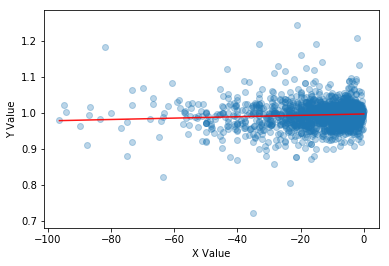

In [0]:
import statsmodels.api as sm
from statsmodels import regression
def linreg(X,Y):

    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

t=temp[temp['PC_case']==6]
t=t[['PC', 'o2c']].dropna()
t=t[abs(t['PC'])<100]
linreg(t['PC'].values, t['o2c'].values)

In [0]:
temp3=o2c.copy()
temp3=temp3.unstack().reset_index()
temp3.columns=['Ticker', 'Date', 'o2c']
temp3

In [0]:

temp=closedf.shift(1)
temp=temp.unstack().reset_index()
temp.columns=['Ticker', 'Date', 'prev_close']
temp

In [0]:
Archive.shape

(142845, 60)

In [0]:
pt3[['headline', 'PX', 'RAISE/CUT']]['headline'].iloc[3]

'CREDIT SUISSE RAISES PETROPAVLOVSK <POG.L> PRICE TARGET TO 1,490P FROM 1,330P; RATING OUTPERFORM'

In [0]:

import numbers
[x for x in pt3['PX1'].iloc[1] if isinstance(x, numbers.Number)]

[]

In [0]:

        

t=[convert_to_float(x) for x in pt3['PX1'].iloc[1]]
t=[value for value in t if not math.isnan(value)]
t

[28.5, 36.2]

In [0]:
#groupby altid and date. identify stocks 
links=Archive.copy()
gblinks=links.groupby(['day', 'altId'])['earnings'].size().reset_index()
gblinks

In [0]:
"""
## sentimentdata with earnings filter (old)
### Data Paths
data_external='S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data'
data_save='S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/Time_filtered_3am_to_7_55am'

#sentiment_path= data_save+'/full_sample_mapped_all_columns_subjects2.csv'

sentiment_path= data_save+'/full_sample_mapped_all_columns_subjects5.csv' ## this includes all headers and is from 00:00 to 7:55

index_path=data_external+'/O2CIndReturns.csv'

mapping_path=data_external+'/Copy of entities.xlsx'
market_cap_path=data_external+'/MarketCap.csv'
OtoC_path=data_external+'/O2OReturns.csv'
vol_path=data_external+'/voldf.csv'
fx_hist_path=data_external+'/fx_hist.csv'
volume_path=data_external+'/SXXP_vol.csv'
Open_path=data_external+'/OpenSXXP.csv'

vol_path=data_external+'/ALLEUVOL.csv'
volume_path=data_external+'/ALLEUvolume.csv'
Open_path=data_external+'/ALLEUOPEN.csv'
OtoC_path=data_external+'/ALLEU.csv'
mapping_path=data_external+'/ALLEUISINS.csv'
C2Opath=data_external+'/CtoO2.csv'
earnings_calendar_path=data_external+'/binary_earnings_calendar.csv'

fx_path=data_external+'/SXXP Index FX per stock.xlsx'


archive=pd.read_csv(sentiment_path, encoding="ISO-8859-1")
archive=remove_unnamed_cols(archive)

archive=archive.sort_values(by='Timestamp')
archive['Date']=pd.to_datetime(archive['Timestamp']).dt.date
archive=archive.set_index('Date')


archive['ex']=archive['Ticker'].apply(lambda x:x.split(' ')[1])
archive['Tick']=archive['Ticker'].apply(lambda x:x.split(' ')[0])
archive['ex'][archive['ex']=='SM']='SQ'
archive['Ticker']=archive['Tick']+' '+archive['ex'] +' Equity'

##condition on subject
archive=archive.copy()
subject_list=['N2:RCH', 'N2:ACCI', 'N2:BUYB', 'N2:REGS']
#subject_list=['N2:RCH']
archive['subjects_split']=archive['subjects'].apply(lambda x: len(list(set(x.split()) & set(subject_list))))
archive=archive[archive['subjects_split']>0]


## earnings calendar
earn_cal=pd.read_csv(earnings_calendar_path)
earn_cal['Date']=pd.to_datetime(earn_cal['Date']).dt.date
earn_cal=earn_cal.set_index('Date')
earn_cal.columns=earn_cal.columns+' Equity'
earn_cal=earn_cal.unstack().reset_index()
earn_cal.columns=['Ticker', 'Date', 'earnings']
#earn_cal=earn_cal.set_index('Date')

temp=archive.reset_index()
#temp=temp[temp['Ticker'].isin(universe)]
temp=pd.merge(temp, earn_cal, on=['Ticker', 'Date'], how='left')
temp=temp.set_index('Date')
temp=temp[temp['earnings']==1]

## alert filter
temp['alert_filter']=1
temp['alert_filter'][(temp['urgency']==1) & (temp['firstMentionSentence']==0)]=0
temp=temp[temp['alert_filter']!=0]

Archive=temp.copy()
#Archive=archive.copy()
"""

FileNotFoundError: File b'S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/Time_filtered_3am_to_7_55am/full_sample_mapped_all_columns_subjects5.csv' does not exist

In [0]:
## emails
def emails_date(x):
    try:
        x=pd.to_datetime(x)
    except:
        x=np.nan
    return x

def bb_exchange(x):
    try:
        x=x.split()[1]
    except:
        x=np.nan
    return x

def bb_ticker(x):
    try:
        x=x.split()[0]
    except:
        x=np.nan
    return x


email_folder="C:/repo/quant-desk/email_scraper/processed_data/raw_splits/"
file="/condensed_emails.csv"
emails=pd.read_csv(email_folder+file, encoding="ISO-8859-1")    
emails=emails[[col for col in emails if "Unnamed" not in col]]

emails['Date']=emails['Date_UTC'].apply(lambda x:emails_date(x))
emails=emails.dropna(subset=['Date'], axis=0)


emails=emails.set_index('Date').tz_localize('utc')
emails=emails.tz_convert('Europe/London')
emails=emails.reset_index()

emails['time']=emails['Date'].dt.time
emails['day']=emails['Date'].dt.date
emails = emails.set_index('Date').tz_localize(None).reset_index()

emails=emails[(emails['time']>datetime.time(0,0)) & (emails['time']<datetime.time(7,50))]

emails['Positive Sentiment']=emails['Positive Sentiment'].fillna(0)
emails['Negative Sentiment']=emails['Negative Sentiment'].fillna(0)
pos=emails.groupby(['Ticker', 'day'])['Positive Sentiment'].mean().reset_index()
neg=emails.groupby(['Ticker', 'day'])['Negative Sentiment'].mean().reset_index()
bbsignals=pd.merge(pos, neg, on=['Ticker', 'day'])
delete_sigs=bbsignals.copy()

bbsignals['Sentiment']=bbsignals['Positive Sentiment']+bbsignals['Negative Sentiment']

bbsignals=bbsignals.groupby(['Ticker', 'day'])['Sentiment'].mean().reset_index()

bbsignals['ex']=bbsignals['Ticker'].apply(lambda x:bb_exchange(x))
exs=['LN', 'SS', 'DC', 'ID', 'FP', 'GR', 'BB', 'SW', 'NA', 'VI', 'FH', 'SM', 'NO', 'IM', 'AV', 'VX', 'GY', 'SE', 'SQ', 'PL']
bbsignals=bbsignals[bbsignals['ex'].isin(exs)]#.drop('ex', axis=1)
bbsignals['tick']=bbsignals['Ticker'].apply(lambda x:bb_ticker(x))
arc_ticks=Archive['Tick'].unique().tolist()
#bbsignals=bbsignals[bbsignals['tick'].isin(arc_ticks)]
bbsignals=bbsignals[bbsignals['Sentiment']!=0]

bbsignals['sign']=np.sign(bbsignals['Sentiment'])
bbsignals['ex'][bbsignals['ex']=='GR']='GY'
bbsignals['ex'][bbsignals['ex']=='SM']='SQ'

bbsignals['Ticker']=bbsignals['tick']+' '+bbsignals['ex']+' Equity'
bbsignals['day']=pd.to_datetime(bbsignals['day'])

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
"""
temp=delete_sigs.copy()
temp['ex']=temp['Ticker'].apply(lambda x:bb_exchange(x))
exs=['LN', 'SS', 'DC', 'ID', 'FP', 'GR', 'BB', 'SW', 'NA', 'VI', 'FH', 'SM', 'NO', 'IM', 'AV', 'VX', 'GY', 'SE', 'SQ', 'PL']
temp=temp[temp['ex'].isin(exs)]#.drop('ex', axis=1)
temp['tick']=temp['Ticker'].apply(lambda x:bb_ticker(x))

temp['ex'][temp['ex']=='GR']='GY'
temp['ex'][temp['ex']=='SM']='SQ'

temp['Ticker']=temp['tick']+' '+temp['ex']+' Equity'
temp['Date']=pd.to_datetime(temp['day'])
temp['mult']=temp['Positive Sentiment']*temp['Negative Sentiment']
temp['delete']=np.sign(temp['mult'])
delete=temp[['Ticker', 'Date', 'delete']]
delete['Date']=delete['Date'].dt.date
temp=Archive.reset_index()
temp=pd.merge(temp, delete, on=['Date', 'Ticker'], how='left')
temp=temp[temp['delete']!=-1]
temp=temp.set_index('Date')
"""

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
##clean the price data
o2c=pd.read_csv(OtoC_path)
o2c=make_date_index(o2c)
o2c=o2c.sort_index()

vol=pd.read_csv(vol_path)
vol=remove_unnamed_cols(vol)
vol=make_date_index(vol)
vol=vol.sort_index()

volume=pd.read_csv(volume_path)
volume=remove_unnamed_cols(volume)
volume=make_date_index(volume)
volume=volume.sort_index()

opendf=pd.read_csv(Open_path)
opendf=remove_unnamed_cols(opendf)
opendf=make_date_index(opendf)
opendf=opendf.sort_index()

indexdf=pd.read_pickle(index_path)
indexdf['Date']=indexdf['Date'].apply(lambda x:x.date())
indexdf=indexdf.set_index('Date')
indexdf=indexdf-1

fx_histdf=pd.read_csv(fx_hist_path)
fx_histdf=make_date_index(fx_histdf)
fx_histdf=fx_histdf.sort_index()


fxdf=pd.ExcelFile(fx_path)
fxdf=fxdf.parse('Worksheet')
fxdf['Ex']=fxdf['Ticker'].apply(lambda x:x.split(' ')[1])


c2o=pd.read_csv(C2Opath)
c2o=remove_unnamed_cols(c2o)
c2o=make_date_index(c2o)
c2o=c2o.sort_index()

'''
pre computed vol and size groups for the sxxp universe.
if universe is changed these need to be re-computed 
'''

size_groupdf = pd.read_csv(data_external+'/size_quintiles.csv')
size_groupdf = make_date_index(size_groupdf)
size_groupdf = size_groupdf.sort_index()

vol_groupdf = pd.read_csv(data_external+'/vol_thirtiles.csv')
vol_groupdf = make_date_index(vol_groupdf)
vol_groupdf =vol_groupdf.sort_index()

NameError: name 'OtoC_path' is not defined

In [0]:
# futures data
indexdf=pd.read_csv('S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data/ftse_futures.csv')
indexdf=indexdf.rename(columns={'day':'Date'})
indexdf['Date']=pd.to_datetime(indexdf['Date']).dt.date
indexdf=indexdf.set_index('Date')
indexdf=indexdf[['o2c_ba', 'o2c_ab']]/100
indexdf

,o2c_ba,o2c_ab
Date,,
2011-06-01,-0.009269,-0.009463
2011-06-02,-0.002556,-0.002798
2011-06-03,-0.001393,-0.001563
2011-06-06,0.004699,0.004369
2011-06-07,0.002121,0.001922
2011-06-08,-0.008122,-0.008335
2011-06-09,0.008900,0.008627
2011-06-10,-0.014664,-0.014876
2011-06-13,0.000346,0.000130


In [0]:
future=pd.read_csv('S:/NimaOlivier/Jon/Sentiment_Strategy/Data_Storage/External_Data/ZA_c2o_futures.csv')
future=future.rename(columns={'day':'Date'})
future['Date']=pd.to_datetime(future['Date']).dt.date
future=future.set_index('Date')
future=future[['c2o_ba', 'c2o_ab']]/100

In [0]:
temp=volume
temp.columns[:100]#['AALB NA Equity'][temp.index==datetime.date(2012,1,3)]
temp[['AGR AV Equity', 'AMAG AV Equity', 'ANDR AV Equity', 'ATRS AV Equity',
       'ATS AV Equity', 'BHD AV Equity', 'BKUS AV Equity', 'BKUSV AV Equity',
       'BTUV AV Equity', 'BTUVV AV Equity', 'BWO AV Equity', 'BWT AV Equity',
       'C8I AV Equity', 'CAI AV Equity', 'CWI AV Equity', 'DOC AV Equity',
       'EBS AV Equity', 'EVN AV Equity', 'FACC AV Equity', 'FKA AV Equity',
       'FLU AV Equity', 'GAGS AV Equity', 'GAGV AV Equity', 'HED AV Equity',
       'HTI AV Equity', 'IIA AV Equity', 'KTCG AV Equity', 'KTMI AV Equity',
       'LNZ AV Equity', 'LTH AV Equity', 'MAN AV Equity', 'MMK AV Equity',
       'OBS AV Equity', 'OBV AV Equity', 'OESD AV Equity', 'OMV AV Equity',
       'OTS AV Equity', 'OTV AV Equity', 'PAL AV Equity', 'PARS AV Equity',
       'POS AV Equity', 'POST AV Equity', 'PYT AV Equity', 'RAT AV Equity',
       'RBI AV Equity', 'RHI AV Equity', 'ROS AV Equity', 'SBO AV Equity',
       'SEM AV Equity', 'SLBS AV Equity', 'SLBV AV Equity', 'SPI AV Equity',
       'STM AV Equity', 'STR AV Equity', 'SWUT AV Equity', 'TKA AV Equity',
       'UBS AV Equity', 'UIV AV Equity', 'UQA AV Equity', 'VER AV Equity',
       'VIG AV Equity', 'VLA AV Equity', 'VOE AV Equity', 'WIE AV Equity',
       'WOL AV Equity', 'WPB AV Equity', 'WXF AV Equity', 'ZAG AV Equity']][temp.index==datetime.date(2012,1,3)]

,AGR AV Equity,AMAG AV Equity,ANDR AV Equity,ATRS AV Equity,ATS AV Equity,BHD AV Equity,BKUS AV Equity,BKUSV AV Equity,BTUV AV Equity,BTUVV AV Equity,...,UQA AV Equity,VER AV Equity,VIG AV Equity,VLA AV Equity,VOE AV Equity,WIE AV Equity,WOL AV Equity,WPB AV Equity,WXF AV Equity,ZAG AV Equity
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,125.0,484.0,1261.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,291.0,952.0,NaN,10094.0,2100.0,NaN,NaN,2626.0,532.0


In [0]:
temp=opendf.unstack().reset_index()
temp['ex']=temp['level_0'].apply(lambda x:x.split()[1])
temp['ex'].unique()
archive['day'].iloc[0]

'2011-01-04'

In [0]:
def groups_per_day(df, splits):
    df = df.dropna(how='all', axis=0)
    df_index=df.index.tolist()

    temp=df.unstack().reset_index()
    temp.columns=['Ticker', 'Date', 'voi']
    groups_app=[]
    for i in df_index:
        sub_temp=temp[temp['Date']==i]
        sub_temp['group']=pd.qcut(sub_temp['voi'], splits, labels=False)
        groups_app.append(sub_temp)
        print(i)
    voi_temp=pd.concat(groups_app)
    voi_group=voi_temp.pivot(values='group', columns='Ticker', index='Date')
    voi_group=voi_group+1
    return voi_group

fair_price_lb=180
vol_split=3
size_split=5

# vol groups
vol_groups=vol.fillna(method='ffill')
vol_groups=vol.rolling(fair_price_lb, min_periods=fair_price_lb).median()
vol_groupdf=groups_per_day(vol_groups, vol_split)

#size groups
size_groups=tot_traded_fx.copy()
size_groups=size_groups.dropna(how='all', axis=0)
size_groups=size_groups.interpolate()
size_mean=size_groups.rolling(fair_price_lb, min_periods=fair_price_lb).mean()
size_groupdf=groups_per_day(size_mean, size_split)

#size_groupdf.to_csv(data_external+'/size_quintiles.csv')
#vol_groupdf.to_csv(data_external+'/vol_thirtiles.csv')

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2011-09-05
2011-09-06
2011-09-07
2011-09-08
2011-09-09
2011-09-12
2011-09-13
2011-09-14
2011-09-15
2011-09-16
2011-09-19
2011-09-20
2011-09-21
2011-09-22
2011-09-23
2011-09-26
2011-09-27
2011-09-28
2011-09-29
2011-09-30
2011-10-03
2011-10-04
2011-10-05
2011-10-06
2011-10-07
2011-10-10
2011-10-11
2011-10-12
2011-10-13
2011-10-14
2011-10-17
2011-10-18
2011-10-19
2011-10-20
2011-10-21
2011-10-24
2011-10-25
2011-10-26
2011-10-27
2011-10-28
2011-10-31
2011-11-01
2011-11-02
2011-11-03
2011-11-04
2011-11-07
2011-11-08
2011-11-09
2011-11-10
2011-11-11
2011-11-14
2011-11-15
2011-11-16
2011-11-17
2011-11-18
2011-11-21
2011-11-22
2011-11-23
2011-11-24
2011-11-25
2011-11-28
2011-11-29
2011-11-30
2011-12-01
2011-12-02
2011-12-05
2011-12-06
2011-12-07
2011-12-08
2011-12-09
2011-12-12
2011-12-13
2011-12-14
2011-12-15
2011-12-16
2011-12-19
2011-12-20
2011-12-21
2011-12-22
2011-12-23
2011-12-26
2011-12-27
2011-12-28
2011-12-29
2011-12-30
2012-01-02
2012-01-03
2012-01-04
2012-01-05
2012-01-06
2012-01-09

KeyboardInterrupt: 

In [0]:
size_groupdf.to_csv(data_external+'/size_quintiles_whole_uni.csv')
vol_groupdf.to_csv(data_external+'/vol_thirtiles_whole_uni.csv')

In [0]:
import time
mapfile=pd.read_csv("S:\\JohnGeary\\Sentiment\\TRNA_data\\maps\\mapped_universe.csv",keep_default_na=False)
mapfile['Ticker']=mapfile['Ticker']+' Equity'
mapfile=mapfile.dropna(subset=['ex'], axis=0)
tickers=mapfile['Ticker'].unique().tolist()
tickers=[t.replace(" SW ", " VX ") for t in tickers]

"""
today=pd.to_datetime(time.strftime("%x")).date()
tomorrow=today + datetime.timedelta(days= 7-today.weekday() if today.weekday()>3 else 1)

locates=pd.read_csv('S:/BackOffice/Locate/Feeds/NimaMultiFactor/Out/Request_EU_'+today.strftime('%Y%m%d')+'.txt')
locates['Ticker']=locates['Ticker']+' Equity'


locates['tick']=locates['Ticker'].apply(lambda x:x.split()[0])
locates['ex']=locates['Ticker'].apply(lambda x:x.split()[1])
locates=locates[locates['ex']!='Equity']
locates[locates['ex']=='SQ']='SM'
#locates[locates['ex']=='SW']='VX'
locates[locates['ex']=='SE']='VX'
locates['Ticker']=locates['tick']+' '+locates['ex']+' Equity'
ltickers=locates['Ticker'].unique().tolist()
"""


'\ntoday=pd.to_datetime(time.strftime("%x")).date()\ntomorrow=today + datetime.timedelta(days= 7-today.weekday() if today.weekday()>3 else 1)\n\nlocates=pd.read_csv(\'S:/BackOffice/Locate/Feeds/NimaMultiFactor/Out/Request_EU_\'+today.strftime(\'%Y%m%d\')+\'.txt\')\nlocates[\'Ticker\']=locates[\'Ticker\']+\' Equity\'\n\n\nlocates[\'tick\']=locates[\'Ticker\'].apply(lambda x:x.split()[0])\nlocates[\'ex\']=locates[\'Ticker\'].apply(lambda x:x.split()[1])\nlocates=locates[locates[\'ex\']!=\'Equity\']\nlocates[locates[\'ex\']==\'SQ\']=\'SM\'\n#locates[locates[\'ex\']==\'SW\']=\'VX\'\nlocates[locates[\'ex\']==\'SE\']=\'VX\'\nlocates[\'Ticker\']=locates[\'tick\']+\' \'+locates[\'ex\']+\' Equity\'\nltickers=locates[\'Ticker\'].unique().tolist()\n'

In [0]:
mapfile=pd.read_csv("S:\\JohnGeary\\Sentiment\\TRNA_data\\maps\\mapped_universe.csv")
mapfile[mapfile['ex']=='np.nan']

,Unnamed: 0,RIC,PERMID,Ticker,SECCODE,ID,ex


In [0]:
sorted(locates['ex'].unique().tolist())

['AV',
 'BB',
 'DC',
 'FH',
 'FP',
 'GA',
 'GY',
 'ID',
 'IM',
 'IT',
 'LN',
 'NA',
 'NO',
 'PL',
 'PW',
 'RX',
 'SM',
 'SS',
 'TI',
 'VX']

In [0]:
"""
a_universe=Archive['Ticker'].unique().tolist()

u=intersection(a_universe, tickers)
len(tickers)
"""

1498

In [0]:
#len(ltickers)
#len(tickers)

#m_universe=list(set(tickers)&set(ltickers))


a_universe=Archive['Ticker'].unique().tolist()
returns_uni=o2c.columns.tolist()
vol_uni=volume.columns.tolist()
universe=intersection(a_universe, returns_uni)
universe=intersection(universe, vol_uni)
universe=intersection(universe, tickers)

impact_list=impact_grp['ticks'].tolist()
universe=intersection(universe, impact_list)

In [0]:
ex=[col.split()[1] for col in tickers]
set(ex)
len(universe)

1300

In [0]:

impact_list=impact_grp['ticks'].tolist()
#n=[c.split()[1] for c in n]
sorted(set(list(set(universe)^set(n))) &set(universe))

['RHI AV Equity']

In [0]:
sorted(mapfile['ex'].unique().tolist())

['AV',
 'BB',
 'DC',
 'FH',
 'FP',
 'GY',
 'ID',
 'IM',
 'LN',
 'NO',
 'PL',
 'SM',
 'SS',
 'SW']

In [0]:
sorted(mapfile[mapfile['Ticker'].isin(universe)]['ex'].unique().tolist())

['AV', 'BB', 'DC', 'FH', 'FP', 'GY', 'ID', 'IM', 'LN', 'NO', 'PL', 'SM', 'SS']

In [0]:
returns_uni=o2c.columns.tolist()
list(set([t.split()[1] for t in tickers]))

['SM',
 'IM',
 'LN',
 'DC',
 'NO',
 'PL',
 'VX',
 'GY',
 'FH',
 'FP',
 'SS',
 'BB',
 'ID',
 'AV']

In [0]:
# all feed 
a_universe=Archive['Ticker'].unique().tolist()
returns_uni=o2c.columns.tolist()
vol_uni=volume.columns.tolist()
universe=intersection(a_universe, returns_uni)
universe=intersection(universe, vol_uni)


In [0]:
universe=intersection(universe, t)

In [0]:
tempcol=list(set(u)^set(universe))

temp=[]
for i in range(len(tempcol)):
    temp.append(tempcol[i].split()[1])
set(temp)

{'AV',
 'BB',
 'DC',
 'FH',
 'FP',
 'GY',
 'ID',
 'IM',
 'LN',
 'NA',
 'NO',
 'PL',
 'SM',
 'SS',
 'VX'}

In [0]:
#get the universe

# sxxp universe
sxxp=pd.read_pickle(market_cap_path)
sxxp_universe=sxxp['Ticker'].values.tolist()

#returns universe
returns_uni=o2c.columns.tolist()

#sxxp contained in sentiment
sxxp_archive=Archive[Archive['Ticker'].isin(sxxp_universe)]
archive_uni=sxxp_archive['Ticker'].unique().tolist()

#our universe i.e the sxxp universe of both returns and archive data intersection
universe=intersection(returns_uni, archive_uni)


In [0]:
#overall universe

# sxxp universe
#sxxp=pd.read_pickle(market_cap_path)
#sxxp_universe=sxxp['Ticker'].values.tolist()
archive_uni=archive['Ticker'].unique().tolist()

#returns universe
returns_uni=o2c.columns.tolist()

#sxxp contained in sentiment
#our universe i.e the sxxp universe of both returns and archive data intersection
universe=intersection(returns_uni, archive_uni)

In [0]:
missing=list(set(earn_cal.columns.tolist())^set(universe))


In [0]:
temp=signalsdf.unstack().reset_index()
temp.columns=['Ticker', 'day', 'signals']
temp=temp[temp['signals']!=0]
temp['signals']=abs(temp['signals'])
temp['month']=temp['day'].apply(lambda x:x.month)
temp['year']=temp['day'].apply(lambda x:x.year)
temp=temp[['Ticker', 'month', 'year', 'signals']].drop_duplicates()
temp=temp.groupby(['month', 'year'])['signals'].sum().reset_index()
temp.columns=['month', 'year', 'sxxp_uni_obs']
temp1=pd.read_csv('dyn_uni_per_month.csv')
temp1=temp1[[col for col in temp1.columns if 'Unnamed' not in col]]
temp=pd.merge(temp, temp1, on=['month', 'year'])
temp.columns=['month', 'year', 'sxxp_uni_signals', 'dyn_uni_signals']
temp=temp.sort_values(by=['year', 'month'])
temp.to_csv('signals_per_month.csv')

,month,year,sxxp_uni_signals,dyn_uni_signals
0,1,2012,294.0,330.0
5,2,2012,293.0,335.0
11,3,2012,293.0,336.0
17,4,2012,258.0,296.0
22,5,2012,259.0,315.0
27,6,2012,267.0,290.0
32,7,2012,292.0,327.0
37,8,2012,275.0,314.0
42,9,2012,256.0,264.0
47,10,2012,219.0,234.0


In [0]:
temp=temp[temp['year']<2017]
temp.groupby('year')['sxxp_uni_signals','dyn_uni_signals'].mean()#.to_csv('average_monthly_signals_per_year.csv')

,sxxp_uni_signals,dyn_uni_signals
year,,
2012,257.166667,286.583333
2013,287.833333,311.583333
2014,298.083333,333.083333
2015,375.416667,447.916667
2016,374.916667,457.416667


In [0]:
# limit data to the universe
o2c=o2c[universe]
vol=vol[universe]
volume=volume[universe]
opendf=opendf[universe]
c2o=c2o[universe]
#sxxp_archive=sxxp_archive[sxxp_archive['Ticker'].isin(universe)]
sxxp_archive=Archive[Archive['Ticker'].isin(universe)]
bbsignals=bbsignals[bbsignals['Ticker'].isin(universe)]
impact_grp=impact_grp[impact_grp['ticks'].isin(universe)]

In [0]:
sxxp_archive.shape
temp2=pd.read_csv('dyn_uni_per_month.csv')

In [0]:
temp=sxxp_archive.copy()
temp['day']=pd.to_datetime(temp['day'])
temp['month']=temp['day'].dt.month
temp['year']=temp['day'].dt.year
temp=temp[['Ticker', 'year', 'month']]
temp=temp.drop_duplicates()
temp=temp.groupby(['year', 'month'])['Ticker'].size().reset_index()
temp.columns=[['year', 'month', 'sxxp_uni']]
temp=pd.merge(temp, temp2, on=['year', 'month'])
temp=temp[[col for col in temp.columns if 'Unnamed' not in col]]
temp=temp[temp['year']<2017]
temp.to_csv("names_per_month_in_sentiment_data.csv")

In [0]:
# put in a quick check here for universe
tempcol=o2c.columns.tolist()
temp=[]
for i in range(len(tempcol)):
    temp.append(tempcol[i].split()[1])
set(temp)

{'AV',
 'BB',
 'DC',
 'FH',
 'FP',
 'GY',
 'ID',
 'IM',
 'LN',
 'NA',
 'NO',
 'PL',
 'SM',
 'SS',
 'VX'}

In [0]:
pd.DataFrame(universe, columns=['sxxp']).to_csv('S:/JohnGeary/Universe/original_universe.csv')

In [0]:
## read in the vix data

#vix=pd.read_csv()

vix_path=data_external
vix=pd.ExcelFile(data_external+"\\Vol v2x vs sx5e.xlsx")

vix = vix.parse("Worksheet")
vix = vix[5:]
vix.columns = vix.iloc[0].values
vix = vix[1:]
vix = vix.dropna(subset=['Date'], axis=0)
#vix['Date']=pd.datetime(vix['Date']).dt.date
vix=vix.iloc[:, :4]
vix=vix.set_index('Date')
vix=vix[['PX_LAST']]
vix.columns=['vix']
vix

,vix
Date,
2017-11-01,11.7924
2017-10-31,11.9864
2017-10-30,12.8308
2017-10-27,12.4951
2017-10-26,12.9159
2017-10-25,14.5349
2017-10-24,12.9424
2017-10-23,12.5904
2017-10-20,12.2167


In [0]:
vix['Date'].iloc[0]

datetime.datetime(2017, 11, 1, 0, 0)

In [0]:
## settings and parameters

start_window = datetime.time(3, 0, 0, 000000)
end_window = datetime.time(7, 50, 0, 000000)

start_date = datetime.date(2011, 1, 11)
end_date = datetime.date(2017, 6, 1)

exclude = datetime.date(2016, 6,24)
exclude2 = datetime.date(2016, 6,27)

rel = 0.0
rel_start = 0
rel_end = 1

notional_high = 50000
notional = 50000
highS = 0.01#high sentiment
lowS = -0.01


#min_weights=[0.5, 0.5, 0.5, 0.5]
#max_weights=[1.5, 1.5, 1.5, 1.5]

posmult = 5 #3.5
negmult = 5
JUMP_level = 5
nov = 0.2
limits = [0.5,1]
window = 90
group_window=90
zscore_win = 900
mom_window=20

#optimum weighted average weights for factor weights
#w= [2,1,6] 
w=[1,1,1]
std_mults=[-1.5, -0.75, -0.5, 0, 0.5, 0.75, 1.5]
#std_mults_short=[-1.5, -0.5, 0, 0.5, 0.75]
#std_mults_long=[-0.75, -0.5, 0, 0.5, 1.5]


pos_liq_pcs=[0, 0.10, 0.075, 0.05, 0.025, 0, 0.02 ]
neg_liq_pcs=[0.02, 0, 0.025, 0.05, 0.075, 0.10, 0 ]

'''
If the group sizes are changed new data must be processed for rolling
groups. see code at the end of back test.
'''
#vol splits.
vol_group_splits=3
#size group size
size_group_splits=5

#small_cap_impact=[0.000359, 0.000448, 0.000501]
#mid_cap_impact=[0.000254, 0.000321, 0.000366]
#large_cap_impact=[0.000157, 0.000196, 0.000222]

small_cap_impact=[0.0005, 0.0007, 0.001]
mid_cap_impact=[0.00035, 0.00045, 0.0005]
large_cap_impact=[0.0002, 0.00025, 0.000275]


#model = linear_model.Ridge(alpha=0.8)
model = linear_model.BayesianRidge(compute_score=True)

In [0]:
def combine_emails_and_reuters(sentimentdf,bbsignals):
    temp=sentimentdf.unstack().reset_index()
    temp.columns=['Ticker', 'day', 'reuters']
    temp=pd.merge(temp, bbsignals, on=['Ticker', 'day'], how='left')
    #temp=temp.dropna(subset=['Sentiment'], axis=0)
    temp['combo_sign']=np.sign(temp['reuters'])*temp['sign']
    temp['extra']=0
    temp['extra'][temp['combo_sign']==0]=1
    temp['keep']=1
    temp['keep'][temp['combo_sign']==-1]=0

    temp['combo']=temp['reuters']
    temp['combo'][temp['extra']==1]=temp['Sentiment']
    #temp['combo'][temp['keep']==0]=temp['Sentiment']
    
    temp['combo'][temp['combo_sign']==1]=temp['Sentiment'] #replace overlap with bloomberg
    temp['combo'][temp['keep']==0]=0
    sentimentdf=temp.pivot(columns='Ticker', values='combo', index='day')
    return sentimentdf


In [0]:
"""
#calculate the impact matrix
market_cap_path=data_external+'/MarketCap.csv'
market_cap=pd.read_pickle(market_cap_path)

mapping_path=data_external+'/Copy of entities.xlsx'
market_cap_path=data_external+'/MarketCap.csv'
OtoC_path=data_external+'/O2OReturns.csv'
vol_path=data_external+'/voldf.csv'
fx_hist_path=data_external+'/fx_hist.csv'
volume_path=data_external+'/SXXP_vol.csv'
Open_path=data_external+'/OpenSXXP.csv'
"""

"\n#calculate the impact matrix\nmarket_cap_path=data_external+'/MarketCap.csv'\nmarket_cap=pd.read_pickle(market_cap_path)\n\nmapping_path=data_external+'/Copy of entities.xlsx'\nmarket_cap_path=data_external+'/MarketCap.csv'\nOtoC_path=data_external+'/O2OReturns.csv'\nvol_path=data_external+'/voldf.csv'\nfx_hist_path=data_external+'/fx_hist.csv'\nvolume_path=data_external+'/SXXP_vol.csv'\nOpen_path=data_external+'/OpenSXXP.csv'\n"

In [0]:
## backtest

#momentum note this is not lagged
twenty_day_momdf=momentum(o2c.copy(), mom_window)


## form the sentiment scores
arch=winner_takes_all(sxxp_archive, rel, highS, lowS, start_date, end_date, start_window, end_window) #newest

#exclude dates
arch = arch[arch['day']!=exclude]
arch = arch[arch['day']!=exclude2]

subjectsdf, subjects_countdf=subjects_data(arch)

sentimentdf, factors_Xdf=weighted_ave_sentiment(arch, rel_start, rel_end) #newest

#sentimentdf=sentimentdf-sentimentdf

sentimentdf=combine_emails_and_reuters(sentimentdf, bbsignals)
#sentimentdf, factors_Xdf, earnings, rch, news=weighted_ave_sentiment(arch, rel_start, rel_end) #newest

sentimentdf=sentimentdf.reset_index()
sentimentdf['day']=pd.to_datetime(sentimentdf['day']).dt.date
sentimentdf=sentimentdf.set_index('day')

sent_index=sentimentdf.index


long_subs=['N2:BUYB']
short_subs=['N2:ACCI', 'N2:REGS']
#short_subs=['N2:ACCI']



exshorts=exclude_subject_df(long_subs, sent_index, subjectsdf)
#returns a data fram of 1's and 0's. the zeros are where the above subjects occur
exlongs=exclude_subject_df(short_subs, sent_index, subjectsdf)

pos_sent=sentimentdf[sentimentdf>0].fillna(0)
neg_sent=sentimentdf[sentimentdf<0].fillna(0)
pos_sent=pos_sent*exlongs
neg_sent=neg_sent*exshorts

sentimentdf=neg_sent+pos_sent


signalsdf=sentimentdf.copy()
signalsdf[signalsdf>0]=1
signalsdf[signalsdf<0]=-1

tot_traded_fx, vol_open, open_gbp = total_traded_open(opendf, volume, fx_histdf, fxdf)


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [0]:
weights_params, weights_format, factors_list=format_weight_inputs(vol_groupdf, twenty_day_momdf, sentimentdf, size_groupdf, o2c, c2o)


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:108: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__ma

In [0]:
##
def regression_weights_layering_all_svV2(weights_params, weights_format, factors_list, window, zscore_win, minmult, maxmult,  vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv):
    """
    this is the new regression function with the layering occuring after all the weights are calculated.
    this need to be tested more. find out if correct by comparison with the live data.
    """
    
    print('start regression')

    pred_df, beta, features, day_list=rolling_lin_reg_c2o_cases2_all_sv(weights_params, window, factors_list,  vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv)
    print('regression: complete')
    betadf=pd.DataFrame(beta, columns=features)
    betadf['dates']=day_list

    pred_cols=[col for col in pred_df.columns if 'pred' in col]
    weights_cols=[]
    for col in pred_cols:
        pred_df['weights_metric_'+col.split('_')[1]]=pred_df['sign']*pred_df[col] # +*+ and -*- will have high z scores +*- low z scores
        weights_cols.append('weights_metric_'+col.split('_')[1])
    tmppdf=pred_df.dropna()



    tmppdf['row_mean']=np.nanmean(tmppdf[weights_cols], axis=1)
    meandf=tmppdf.groupby('day')['row_mean'].mean().reset_index()
    meandf=meandf.rename(columns={'row_mean':'mean'})
    tmppdf=pd.merge(meandf, tmppdf, on='day')

    std_cols=weights_cols.copy()
    std_cols.append('day')
    std_tmp=tmppdf[std_cols]
    std_tmp=std_tmp.set_index('day')
    std_v=std_tmp.unstack().reset_index()
    std_v.columns=['level', 'day', 'std']
    std_v=std_v.dropna()
    std_v=std_v.groupby('day')['std'].std().reset_index()
    tmppdf=pd.merge(std_v, tmppdf, on='day')

    z_score_cols=[]
    for col in weights_cols:
        tmppdf[col+'_z_score']=(tmppdf[col]-tmppdf['mean'])/tmppdf['std']
        z_score_cols.append(col+'_z_score')
    print('z-scores: complete')
    weight_cols=[]
    for col in z_score_cols:  
        w_col=col.split('metric_')[1]
        tmppdf['_'+w_col+'_weight']=0.5*(1+erf(tmppdf[col])/math.sqrt(2))
        weight_cols.append('_'+w_col+'_weight')

    dfs, dfs_cols=scale_layered_weights(tmppdf, minmult, maxmult, weight_cols)
    print('scaling: complete')

    tf_cols=[col for col in dfs.columns if 'tf' in col]
    #check1=tmppdf.copy()
    layered_cols=[]
    for case in std_mults:
        tf=[s for s in tf_cols if '_'+str(case)+'_' in s ]
        w=[s for s in dfs_cols if '_'+str(case)+'_' in s]
        dfs[w[0]+'_layered']=1
        dfs[w[0]+'_layered']=dfs[tf[0]]*dfs[w[0]]
        layered_cols.append(w[0]+'_layered')
    for case in layered_cols:
        dfs[case][dfs[case]==0]=np.nan

    weights=dfs.copy()
    w_cols=layered_cols.copy()
    #w_cols.remove('day')
    #w_cols.remove('Ticker')

    weight_levels=[]
    for col in w_cols:
        print(col)
        temp=weights.pivot(index='day', values=col, columns='Ticker')
        temp=temp*weights_format
        temp.index.name='Date'
        weight_levels.append(temp)
    return weight_levels, dfs, weights, w_cols, betadf



In [0]:
def rolling_lin_reg_c2o_cases2_all_sv(df, window, features, vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv):
    dates=df['day'].unique().tolist()
    beta=[]
    day_list=[]
    #pred=np.array()
    #print('start rolling lin reg')
    for i in range(len(dates)):
        #print(i)
        if (i <= group_window) & (i==0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            preds=[0]*len(std_mults)
            days=[0]*len(std_mults)
            #tick=[]
            for j in range(len(std_mults)):
                preds[j]=np.tile(np.nan, size)
                days[j]=np.tile(np.nan, size)
            #tick=np.tile(np.nan, size)
            #print(size)
        elif (i<= group_window) & (i!=0):
            temp=df[df['day']==dates[i]]
            size=temp.shape[0]
            for j in range(len(std_mults)):
                preds[j]=np.append(preds[j], np.tile(np.nan, size))
                days[j]=np.append(days[j],np.tile(np.nan, size)) 
            #tick=np.append(tick, np.tile(np.nan, size))
        else:
            
            #model = linear_model.LinearRegression()
            temp=df[df['day']<dates[i]]
            temp=temp[temp['day']>=dates[i-window]]
            
            features=sorted(features)
            #print(features)
            X_train=temp[features]
            Y_train=temp['ret']

            test=df[df['day']==dates[i]]
            #print(test['day'])
            #X-testprop contains the true c2o value.
            X_testprop=test.copy()#[features]

            #get the window over which we compute the mean and std c2o move for each vol/size group for stocks with news 
            c2o_train=all_sv[all_sv['day']<dates[i]]
            c2o_train=c2o_train[c2o_train['day']>=dates[i-group_window]]
            #print(c2o_train.shape)
            c2o_mean=c2o_train.groupby(['vol', 'size'])['c2o'].mean().reset_index()
            c2o_std=c2o_train.groupby(['vol', 'size'])['c2o'].std().reset_index()
            #in cases of nans interpolate
            c2o_mean['c2o_mean']=c2o_mean['c2o'].interpolate()
            c2o_std['c2o_std']=c2o_std['c2o'].interpolate()
            c2o_mean=c2o_mean.drop('c2o', axis=1)
            c2o_std=c2o_std.drop('c2o', axis=1)

            #format c2o df's i.e if nan for a particula vs group at the edge, fill with nearest value
            s_v_format=size_vol_groups_format(vol_group_splits, size_group_splits)

            c2o_mean=pd.merge(c2o_mean, s_v_format, on=['vol', 'size'], how='right').sort_values(by=['vol', 'size'])
            c2o_mean['c2o_mean']=c2o_mean['c2o_mean'].fillna(method='bfill')
            c2o_mean['c2o_mean']=c2o_mean['c2o_mean'].fillna(method='ffill')

            c2o_std=pd.merge(c2o_std, s_v_format, on=['vol', 'size'], how='right').sort_values(by=['vol', 'size'])
            c2o_std['c2o_std']=c2o_std['c2o_std'].fillna(method='bfill')
            c2o_std['c2o_std']=c2o_std['c2o_std'].fillna(method='ffill')            

            #merge the c2o mean and std stats with the test df
            temp_test=X_testprop.copy()
            temp_test=pd.merge(temp_test, c2o_std, on=['vol', 'size'])
            temp_test=pd.merge(temp_test, c2o_mean, on=['vol', 'size'])
            c2o_cases=[]
            #calculate the 5 different cases -1std, -0.5std, 0, etc.

            for case in std_mults:
                temp_test['c2o_'+str(case)]=temp_test['c2o_mean']+case*temp_test['c2o_std']
                c2o_cases.append('c2o_'+str(case))



            #scale the inputs
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            if i== group_window+1:
                tests=temp_test
            else:
                frames=[tests, temp_test]
                tests=pd.concat(frames)
            #tests[]
            model.fit(X_train, Y_train)
            beta.append(model.coef_)
            day_list.append(dates[i])
            k=0
            for case in c2o_cases:
                test_features=features.copy()
                test_features.remove('c2o')
                test_features.append(case)
                size=temp_test.shape[0]
                test_features=sorted(test_features)
                #print(test_features)
                X_test=temp_test[test_features]
                X_test= scaler.transform(X_test)
                preds[k] = np.append(preds[k], model.predict(X_test))  
                days[k]=np.append(days[k],np.tile(dates[i], size))

                k=k+1

    preddf=tests.reset_index().drop('index', axis=1)
    j=0
    for col in preds:
        temp=pd.DataFrame(col).dropna().reset_index().drop('index', axis=1)
        preddf['pred_'+str(std_mults[j])]=temp
        j=j+1

    temp=preddf.copy()
    temp_pos=temp[temp['sentiment']>=0]
    temp_neg=temp[temp['sentiment']<0]

    '''

    '''
    for case in c2o_cases:
        temp=(temp_pos[case]>temp_pos['c2o']).astype(int)
        temp_pos[case+'_tf']=(temp_pos[case]*temp)#/temp_pos[case]
        temp_pos[case+'_tf'][temp_pos[case+'_tf']!=0]=1
        temp=(temp_neg[case]<temp_neg['c2o']).astype(int)
        temp_neg[case+'_tf']=(temp_neg[case]*temp)#/temp_pos[case]
        temp_neg[case+'_tf'][temp_neg[case+'_tf']!=0]=1

    frames=[temp_pos, temp_neg]
    test_layers=pd.concat(frames)
    test_layers=test_layers.sort_values(by='day')

    return test_layers, beta, features, day_list

In [0]:
temp=weights_params[:3000]
all_sv=size_vol_all_inclusive(size_groupdf, vol_groupdf, c2o)
pred_df, beta, features, d=rolling_lin_reg_c2o_cases2_all_sv(temp, window, factors_list,  vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv)



C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: too many values to unpack (expected 4)

In [0]:

def weighted_constrained_levels_fut(nominal, nominal_high, posmult, negmult, weights, 
                                tot_traded_fx, pos_liq_pcs, neg_liq_pcs, signalsdf, o2c, indexdf):
    tot_opendf=tot_traded_fx.copy()
    tot_vec=tot_opendf.unstack().reset_index()
    tot_vec.columns=[['Ticker','Date', 'Total']]
    g1=tot_vec.groupby('Ticker')['Total'].mean().reset_index()

    g1=g1.sort('Total')
    g1=g1.reset_index()
    a=g1.index.tolist()
    top=g1[350:]['Ticker'].tolist()
    bottom=g1[:350]['Ticker'].tolist()

    #these hold the maximum liquidity available at the different levels
    posmaxdfs=[]
    negmaxdfs=[]
    for pc in pos_liq_pcs:
        posmaxdfs.append(tot_opendf*pc)
    for pc in neg_liq_pcs:
        negmaxdfs.append(tot_opendf*pc)

    signalsdf[signalsdf>0]=1
    signalsdf[signalsdf<0]=-1

    pos_s=signalsdf[signalsdf>0]
    neg_s=signalsdf[signalsdf<0]

    pos_maxtradeabledfs=[]
    neg_maxtradeabledfs=[]
    for pmax in posmaxdfs:
        temp=(pmax*pos_s).fillna(0)
        pos_maxtradeabledfs.append(temp)
    for nmax in negmaxdfs:
        temp=(nmax*neg_s).fillna(0)
        neg_maxtradeabledfs.append(temp)


    countdf=pd.DataFrame()

    countdf['Count_Pos']=(signalsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Count_Neg']=(signalsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['total_count']=countdf['Count_Pos']+countdf['Count_Neg']
    countdf['long_fixed']=nominal*posmult
    countdf['short_fixed']=nominal*negmult
    countdf['high_long_fixed']=nominal_high*posmult
    countdf['high_short_fixed']=nominal_high*negmult

    longsignalsdfs=[]
    shortsignalsdfs=[]
    for pos_max in pos_maxtradeabledfs:
        temp=pos_max.copy()
        temp[temp>0]=1
        temp=temp.fillna(0)
        longsignalsdfs.append(temp)
    for neg_max in neg_maxtradeabledfs:
        temp=neg_max.copy()
        temp[temp<0]=-1
        temp=temp.fillna(0)
        shortsignalsdfs.append(temp)

    #now split into bucketsn for notional assignment
    lowlongsignalsdfs=[]
    lowshortsignalsdfs=[]
    for longdf in longsignalsdfs:
        templongsignalsdf=longdf[bottom]
        lowlongsignalsdf=templongsignalsdf.multiply(countdf['long_fixed'], axis="index")
        lowlongsignalsdfs.append(lowlongsignalsdf)
    for shortdf in shortsignalsdfs:    
        tempshortsignalsdf=shortdf[bottom]
        lowshortsignalsdf=tempshortsignalsdf.multiply(countdf['short_fixed'], axis="index")
        lowshortsignalsdfs.append(lowshortsignalsdf)

    highlongsignalsdfs=[]
    highshortsignalsdfs=[]
    for longdf in longsignalsdfs:
        templongsignalsdf=longdf[top]
        highlongsignalsdf=templongsignalsdf.multiply(countdf['high_long_fixed'], axis="index")
        highlongsignalsdfs.append(highlongsignalsdf)
    for shortdf in shortsignalsdfs:    
        tempshortsignalsdf=shortdf[top]
        highshortsignalsdf=tempshortsignalsdf.multiply(countdf['high_short_fixed'], axis="index")
        highshortsignalsdfs.append(highshortsignalsdf)

    highlowlongsignalsdfs=[]
    highlowshortsignalsdfs=[]
    for i in range(len(highlongsignalsdfs)):
        highlowlongsignalsdfs.append(pd.merge(highlongsignalsdfs[i], lowlongsignalsdfs[i], left_index=True,right_index=True).fillna(0))
    for i in range(len(highshortsignalsdfs)):
        highlowshortsignalsdfs.append(pd.merge(highshortsignalsdfs[i], lowshortsignalsdfs[i], left_index=True,right_index=True).fillna(0))


    long_weighted_notionaldfs=[]
    short_weighted_notionaldfs=[]
    for i in range(len(weights)):
        w=weights[i]
        long_notionals=highlowlongsignalsdfs[i]
        short_notionals=highlowshortsignalsdfs[i]
        l_n=(long_notionals*w).fillna(0)
        s_n=(short_notionals*w).fillna(0)
        long_weighted_notionaldfs.append(l_n)
        short_weighted_notionaldfs.append(s_n)

    long_notional_pcliqdfs=[]
    for i in range(len(long_weighted_notionaldfs)):
        long_notionaldf=long_weighted_notionaldfs[i]
        pmax_tradeabledf=pos_maxtradeabledfs[i]
        long_notionaldf=long_notionaldf.where(long_notionaldf<pmax_tradeabledf, pmax_tradeabledf).fillna(long_notionaldf)
        long_notional_pcliqdfs.append(long_notionaldf)

    short_notional_pcliqdfs=[]
    for i in range(len(short_weighted_notionaldfs)):
        short_notionaldf=short_weighted_notionaldfs[i]
        nmax_tradeabledf=neg_maxtradeabledfs[i]
        short_notionaldf=short_notionaldf.where(short_notionaldf>nmax_tradeabledf, nmax_tradeabledf).fillna(short_notionaldf)
        short_notional_pcliqdfs.append(short_notionaldf)

    long_open_posdfs=[]
    for l in long_notional_pcliqdfs:
        long=l.copy()
        long[long>0]=1
        long=o2c*long
        formatret=(o2c/o2c).fillna(0)
        lsig=l*formatret
        long_open_posdfs.append(lsig)

    short_open_posdfs=[]
    for s in short_notional_pcliqdfs:
        short=s.copy()
        short[short<0]=1
        short=o2c*short
        formatret=(o2c/o2c).fillna(0)
        ssig=s*formatret
        short_open_posdfs.append(ssig)

    longreturnsdfs=[]
    for long_pos in long_open_posdfs:
        longreturnsdf=o2c*long_pos
        longreturnsdf=longreturnsdf.fillna(0)
        longreturnsdfs.append(longreturnsdf)

    shortreturnsdfs=[]
    for short_pos in short_open_posdfs:
        shortreturnsdf=o2c*short_pos
        shortreturnsdf=shortreturnsdf.fillna(0)
        shortreturnsdfs.append(shortreturnsdf)

    k=0
    for long_pos in long_open_posdfs:
        if k==0:
            combo_longposdf=long_pos
        else:
            combo_longposdf=long_pos+combo_longposdf
        k=k+1

    k=0
    for short_pos in short_open_posdfs:
        if k==0:
            combo_shortposdf=short_pos
        else:
            combo_shortposdf=short_pos+combo_shortposdf
        k=k+1


    k=0
    for long_ret in longreturnsdfs:
        if k==0:
            combo_longreturnsdf=long_ret
        else:
            combo_longreturnsdf=combo_longreturnsdf+long_ret
        k=k+1

    k=0
    for short_ret in shortreturnsdfs:
        if k==0:
            combo_shortreturnsdf=short_ret
        else:
            combo_shortreturnsdf=combo_shortreturnsdf+short_ret
        k=k+1

    countdf['Constrained_Count_Pos']=(combo_longreturnsdf > 0).astype(int).sum(axis=1) #number of positive sentiment articlas
    countdf['Constrained_Count_Neg']=(combo_shortreturnsdf < 0).astype(int).sum(axis=1) #number of negative sentiment articles
    countdf['Constrained_total_count']=countdf['Constrained_Count_Pos']+countdf['Constrained_Count_Neg']
    portfolio=pd.DataFrame()
    portfolio['long_Day_end']=combo_longreturnsdf.sum(axis=1)
    portfolio['short_Day_end']=combo_shortreturnsdf.sum(axis=1)
    portfolio['long_Day_start']=combo_longposdf.sum(axis=1)
    portfolio['short_Day_start']=combo_shortposdf.sum(axis=1)

    portfolio['Diff_long']=portfolio['long_Day_end']-portfolio['long_Day_start']
    portfolio['Diff_short']=portfolio['short_Day_end']-portfolio['short_Day_start']
    portfolio['raw_profit']=portfolio['Diff_long']+portfolio['Diff_short']
    portfolio['acc_raw_profit']=portfolio['raw_profit'].cumsum()

    copydf=indexdf.copy()
    portfolio=pd.merge(portfolio, copydf, right_index=True, left_index=True, how='left')
    portfolio['tot_invested']=-portfolio['short_Day_start']+portfolio['long_Day_start']
    portfolio['delta_Day_start']=-(portfolio['short_Day_start']+portfolio['long_Day_start'])
    portfolio['tot_invested_plus_hedge']=portfolio['tot_invested']+abs(portfolio['delta_Day_start'])

    portfolio['hedge_sign']=np.sign(portfolio['delta_Day_start'])
    portfolio['o2c_ba'][portfolio['hedge_sign']==1]=0
    portfolio['o2c_ab'][portfolio['hedge_sign']==-1]=0
    portfolio['SXXP Index']=portfolio['o2c_ba']+portfolio['o2c_ab']

    copydf=portfolio[['SXXP Index']]

    portfolio['delta_Day_end']=portfolio['delta_Day_start']*(portfolio['SXXP Index']+1)
    portfolio['diff_hedge']=portfolio['delta_Day_end']-portfolio['delta_Day_start']
    portfolio['raw_profit_hedged']=portfolio['raw_profit']+portfolio['diff_hedge']
    portfolio['acc_raw_profit_hedged']=portfolio['raw_profit_hedged'].cumsum()
    portfolio['hedge_ret']=portfolio['raw_profit_hedged']/portfolio['tot_invested_plus_hedge']

    del portfolio['SXXP Index']

    allinfodf=pd.merge(countdf, portfolio, right_index=True, left_index=True)
    allinfodf['returns']=(allinfodf['Diff_short']+allinfodf['Diff_long'])/(allinfodf['tot_invested'])
    #allinfodf['ret_per_trade']=((allinfodf['Diff_short']+allinfodf['Diff_long'])/allinfodf['total_count'])/(nominal)+1
    allinfodf['ret_per_short_trade']=(allinfodf['Diff_short']/allinfodf['Count_Neg'])/nominal+1
    allinfodf['ret_per_long_trade']=(allinfodf['Diff_long']/allinfodf['Count_Pos'])/nominal+1

    allinfodf=pd.merge(allinfodf, copydf, right_index=True, left_index=True, how='left')
    allinfodf['returns_detrend']=allinfodf['returns']-allinfodf['SXXP Index']
    allinfodf['ratio_pos_neg']=(allinfodf['Count_Pos']+1)/(allinfodf['Count_Neg']+1)

    return allinfodf, combo_longreturnsdf, combo_shortreturnsdf, combo_longposdf, combo_shortposdf

In [0]:
betadf

,c2o,momentum,sentiment,size,vol,dates
0,-0.363365,0.137710,0.293345,0.013312,0.104978,2011-09-22
1,-0.271087,0.133225,0.227313,0.015587,0.118398,2011-09-23
2,-0.275775,0.133424,0.233058,0.024308,0.122637,2011-09-26
3,-0.304876,0.155557,0.228712,0.019876,0.121713,2011-09-27
4,-0.212649,0.164933,0.192622,0.025323,0.116057,2011-09-28
5,-0.220838,0.148465,0.188967,0.025226,0.139446,2011-09-29
6,-0.226562,0.140075,0.173610,0.028690,0.154651,2011-09-30
7,-0.225859,0.119244,0.167504,0.015632,0.158443,2011-10-03
8,-0.229588,0.137334,0.164619,0.015049,0.154472,2011-10-04
9,-0.213015,0.118160,0.176452,0.021161,0.149170,2011-10-05


In [0]:


all_sv=size_vol_all_inclusive(size_groupdf, vol_groupdf, c2o)
weights, weights_info, w, w_cols, betadf  = regression_weights_layering_all_svV2(weights_params, weights_format, factors_list, window, zscore_win, limits[0], limits[1],  vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv)
#weights, weights_info, w, w_cols  = regression_weights_layering_all_svV2(w, weights_format, factors_list, window, zscore_win, limits[0], limits[1],  vol_group_splits, size_group_splits, std_mults, group_window, model, all_sv)


start regression


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


regression: complete
z-scores: complete
2011-09-22
2011-09-23
2011-09-26
2011-09-27
2011-09-28
2011-09-29
2011-09-30
2011-10-03
2011-10-04
2011-10-05
2011-10-06
2011-10-07
2011-10-10
2011-10-11
2011-10-12
2011-10-13
2011-10-14
2011-10-17
2011-10-18
2011-10-19
2011-10-20
2011-10-21
2011-10-24
2011-10-25
2011-10-26
2011-10-27
2011-10-28
2011-10-31
2011-11-01
2011-11-02
2011-11-03
2011-11-04
2011-11-07
2011-11-08
2011-11-09
2011-11-10
2011-11-11
2011-11-14
2011-11-15
2011-11-16
2011-11-17
2011-11-18
2011-11-21
2011-11-22
2011-11-23
2011-11-24
2011-11-25
2011-11-28
2011-11-29
2011-11-30
2011-12-01
2011-12-02
2011-12-05
2011-12-06
2011-12-07
2011-12-08
2011-12-09
2011-12-12
2011-12-13
2011-12-14
2011-12-15
2011-12-16
2011-12-19
2011-12-20
2011-12-21
2011-12-22
2011-12-23
2011-12-27
2012-01-03
2012-01-04
2012-01-05
2012-01-06
2012-01-09
2012-01-10
2012-01-11
2012-01-12
2012-01-13
2012-01-16
2012-01-17
2012-01-18
2012-01-19
2012-01-20
2012-01-23
2012-01-24
2012-01-25
2012-01-26
2012-01-27
201

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


_-1.5_weight_layered
_-0.75_weight_layered
_-0.5_weight_layered
_0_weight_layered
_0.5_weight_layered
_0.75_weight_layered
_1.5_weight_layered


In [0]:
W=weights.copy()
pos=signalsdf[signalsdf>=0].fillna(0)
pos[pos==1]=np.nan
pos[pos==0]=1
neg=signalsdf[signalsdf<=0].fillna(0)
neg[neg==-1]=np.nan
neg[neg==0]=1
neg

Ticker,1COV GY Equity,888 LN Equity,A2A IM Equity,A3M SM Equity,AA/ LN Equity,AAK SS Equity,AAL LN Equity,AB FP Equity,AB1 GY Equity,ABBN VX Equity,...,YTY1V FH Equity,ZAG AV Equity,ZAL GY Equity,ZC FP Equity,ZEAL DC Equity,ZIL2 GY Equity,ZO1 GY Equity,ZOT SM Equity,ZPG LN Equity,ZURN VX Equity
day,,,,,,,,,,,,,,,,,,,,,
2011-01-11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011-01-12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011-01-13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011-01-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011-01-17,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011-01-18,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011-01-19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2011-01-20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011-01-21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
W=weights.copy()
pos=signalsdf[signalsdf>=0].fillna(0)
pos[pos==1]=np.nan
pos[pos==0]=1
neg=signalsdf[signalsdf<=0].fillna(0)
neg[neg==-1]=np.nan
neg[neg==0]=1

## in terms of positive signals

#delete_from='agg'
#keep_from='agg'

keep=6 # 0 is the most agressive


# keep aggressive layers, i.e buy high
#if keep_from=='pass':
for i in range(len(W)):
    if i != keep:
        W[i]=W[i]*pos
        W[len(W)-1-i]=W[len(W)-1-i]*neg

"""
#delet aggressive levels i.e buy low
if keep_from=='agg':
    for i in range(len(W)):
        W[i]=W[i]*neg
        W[len(W)-1-i]=W[len(W)-1-i]*pos
"""
"""
# keep aggressive layers, i.e buy high
if delete_from=='pass':
    for i in range(remove):
        W[i]=W[i]*pos
        W[len(W)-1-i]=W[len(W)-1-i]*neg

#delet aggressive levels i.e buy low
if delete_from=='agg':
    for i in range(remove):
        W[i]=W[i]*neg
        W[len(W)-1-i]=W[len(W)-1-i]*pos
"""

"\n# keep aggressive layers, i.e buy high\nif delete_from=='pass':\n    for i in range(remove):\n        W[i]=W[i]*pos\n        W[len(W)-1-i]=W[len(W)-1-i]*neg\n\n#delet aggressive levels i.e buy low\nif delete_from=='agg':\n    for i in range(remove):\n        W[i]=W[i]*neg\n        W[len(W)-1-i]=W[len(W)-1-i]*pos\n"

In [0]:
W=weights.copy()


In [0]:
pos_liq_pcs
neg_liq_pcs=[0.02, 0, 0.025, 0.05, 0.075, 0.1, 0]
pos_pcs=[0.0, 0, 0.02, 0.025, 0.05, 0.075, 0.1]
neg_pcs=[0.1, 0.075, 0.05,0.25,0.02,0,0]

pos_pcs=pos_liq_pcs.copy()
neg_pcs=neg_liq_pcs.copy()
pos_pcs=[0.0, 0, 0.05, 0.05, 0.05, 0, 0.05]
neg_pcs=[0.05, 0, 0.05,0.05,0.05,0,0]
pos_pcs=pos_liq_pcs.copy()
neg_pcs=neg_liq_pcs.copy()

In [0]:
pos_pcs=pos_liq_pcs.copy()
neg_pcs=neg_liq_pcs.copy()
pos_pcs=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
neg_pcs=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

In [0]:
weights_info[['c2o_-1.5', 'c2o_-0.75', 'c2o_-0.5', 'c2o_0', 'c2o_0.5',
       'c2o_0.75', 'c2o_1.5', 'size', 'vol']]

,c2o_-1.5,c2o_-0.75,c2o_-0.5,c2o_0,c2o_0.5,c2o_0.75,c2o_1.5,size,vol
0,-2.332838,-1.158461,-0.767001,0.015917,0.798835,1.190294,2.364671,5.0,2.0
1,-3.455271,-1.667431,-1.071484,0.120409,1.312302,1.908249,3.696089,5.0,-3.0
2,-1.687173,-0.848433,-0.568853,-0.009693,0.549467,0.829046,1.667786,5.0,-1.0
3,-1.687173,-0.848433,-0.568853,-0.009693,0.549467,0.829046,1.667786,5.0,1.0
4,-2.685124,-1.322302,-0.868028,0.040520,0.949068,1.403341,2.766163,1.0,-2.0
5,-1.687173,-0.848433,-0.568853,-0.009693,0.549467,0.829046,1.667786,5.0,-1.0
6,-2.332838,-1.158461,-0.767001,0.015917,0.798835,1.190294,2.364671,5.0,2.0
7,-2.332838,-1.158461,-0.767001,0.015917,0.798835,1.190294,2.364671,5.0,2.0
8,-1.687173,-0.848433,-0.568853,-0.009693,0.549467,0.829046,1.667786,5.0,-1.0
9,-3.455271,-1.667431,-1.071484,0.120409,1.312302,1.908249,3.696089,5.0,-3.0


In [0]:
c2ob=betadf[['c2o', 'dates']]
c2ob.columns=['beta', 'Date']
c2ob=c2ob.set_index('Date')
c2ob

,beta
Date,
2011-09-22,-0.363365
2011-09-23,-0.271087
2011-09-26,-0.275775
2011-09-27,-0.304876
2011-09-28,-0.212649
2011-09-29,-0.220838
2011-09-30,-0.226562
2011-10-03,-0.225859
2011-10-04,-0.229588


In [0]:
def set_num_levels(x):
    if x>0:
           n=0
    elif x<=0:
        n=0
    return n


W=weights.copy()
pos=signalsdf[signalsdf>=0].fillna(0)
pos[pos==1]=np.nan
pos[pos==0]=1
neg=signalsdf[signalsdf<=0].fillna(0)
neg[neg==-1]=np.nan
neg[neg==0]=1

numL=c2ob.copy()
numL['num']=np.nan
numL['num']=numL['beta'].apply(lambda x:set_num_levels(x))
numL=numL[['num']]

dates=numL.index
for date in dates:
    if numL['num'][numL.index==date].values[0]!=0:
        for i in range(numL['num'][numL.index==date].values[0]):
            W[i][W[i].index==date]= W[i][W[i].index==date]*pos[pos.index==date]
            W[len(W)-1-i][W[len(W)-1-i].index==date]=W[len(W)-1-i][W[len(W)-1-i].index==date]*neg[neg.index==date]  
            
pos_pcs=pos_liq_pcs.copy()
neg_pcs=neg_liq_pcs.copy()

In [0]:
##impact
"""
1. match impact levels with tickers in impact_grp df 
2. for each impact level set up an impact dataframe
3. find the participation % for each signal. 
    -return notional invested per name from portfolio function
    -divide this by the total traded
4. split participation df into 3 dfs, 1 for each impact level
5. subtract the impact from the o2c dataframe

"""

In [0]:
#small_cap_impact=[0.000359, 0.000448, 0.000501]
#mid_cap_impact=[0.000254, 0.000321, 0.000366]
#large_cap_impact=[0.000157, 0.000196, 0.000222]
impact=impact_grp.copy()

impact_size_levels=[]
impact_size_levels.append(small_cap_impact)
impact_size_levels.append(mid_cap_impact)
impact_size_levels.append(large_cap_impact)

imp_l=pd.DataFrame(impact_size_levels, columns=['<5%', '<10%', '<15%'])
imp_l=imp_l.reset_index()
imp_l['index']=imp_l['index']+1
imp_l=imp_l.rename(columns={'index':'group'})
impact=pd.merge(impact, imp_l, on='group').drop('ticks', axis=1)
impact.sort_values(by='group')

ret_temp=o2c.copy()
ret_temp=ret_temp.fillna(1)
ret_temp=ret_temp/ret_temp
ret_v=ret_temp.unstack().reset_index()
ret_v.columns=['Ticker', 'Date', 'entry']
ret_v=pd.merge(ret_v, impact, on=['Ticker'], how='left')

impact_dfs=[]
levs=[col for col in ret_v.columns if "%" in col]
for col in levs:
    impact_dfs.append(ret_v.pivot(index='Date', values=col, columns='Ticker'))
    


In [0]:
impact_dfs[0]

Ticker,1COV GY Equity,888 LN Equity,A2A IM Equity,A3M SM Equity,AA/ LN Equity,AAK SS Equity,AAL LN Equity,AALB NA Equity,AB FP Equity,AB1 GY Equity,...,YTY1V FH Equity,ZAG AV Equity,ZAL GY Equity,ZC FP Equity,ZEAL DC Equity,ZIL2 GY Equity,ZO1 GY Equity,ZOT SM Equity,ZPG LN Equity,ZURN VX Equity
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-10,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-11,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-12,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-13,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-14,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-17,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-18,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-19,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254
2011-01-20,0.000254,0.000157,0.000359,0.000359,0.000157,0.000359,0.000157,0.000359,0.000359,0.000359,...,0.000359,0.000359,0.000254,0.000359,0.000359,0.000359,0.000359,0.000359,0.000157,0.000254


In [0]:
pos_pcs
pos_liq_pcs

[0, 0.1, 0.075, 0.05, 0.025, 0, 0.02]

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Sharpe:
3.1031845051593576


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


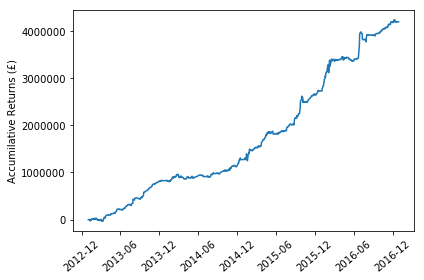

In [0]:
pos_pcs=pos_liq_pcs.copy()
neg_pcs=neg_liq_pcs.copy()
#pos_pcs=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
#neg_pcs=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
def JUMP_constraint(c2o, signalsdf, level):
    #level=JUMP_level
    temp=c2o.copy()

    temp=(temp-1)*100

    temp[temp>=level]=0
    temp[temp<=-level]=0

    temp=temp.fillna(0)
    temp[temp!=0]=1
    temp[temp==0]=np.nan
    #temp=temp[cols]
    template=signalsdf.copy()
    template=(template/template).fillna(1)
    temp_dates=template.copy()
    temp_dates['keep']=1
    temp_dates=temp_dates[['keep']]
    tempdf=signalsdf*temp
    tempdf=tempdf*template
    tempdf=pd.merge(tempdf, temp_dates, right_index=True, left_index=True, how='right').drop('keep', axis=1)
    tempdf=tempdf[signalsdf.columns]
    #tempdf=tempdf.dropna(how='all', axis=0)
    return tempdf

cond_signalsdf=JUMP_constraint(c2o, signalsdf, JUMP_level)
allinfodf,l_end, s_end, l_start, s_start=weighted_constrained_levels_fut(notional, notional_high, posmult, negmult, weights, tot_traded_fx, pos_pcs, neg_pcs, cond_signalsdf, o2c, indexdf)
allinfodf=allinfodf.reset_index()

tmpdf=allinfodf.copy()
tmpdf=tmpdf.set_index('index')
tmpdf=tmpdf[tmpdf.index<=datetime.date(2017,1,1)]
tmpdf=tmpdf[tmpdf.index>=datetime.date(2013,1,1)]
fig=plt.figure()
tmpdf['acc_raw_profit_hedged']=tmpdf['raw_profit_hedged'].cumsum()
plt.plot(tmpdf['acc_raw_profit_hedged'].dropna())

plt.ylabel('Accumilative Returns (£)')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('pnl_chart.jpg')


fig.show()
print('Sharpe:')
print((tmpdf['raw_profit_hedged'].dropna().mean()/tmpdf['raw_profit_hedged'].dropna().std())*16)

In [0]:
tmpdf.mean()

Count_Pos                  2.399707e+01
Count_Neg                  2.428098e+01
total_count                4.827805e+01
long_fixed                 2.500000e+05
short_fixed                2.500000e+05
high_long_fixed            2.500000e+05
high_short_fixed           2.500000e+05
Constrained_Count_Pos      1.944683e+01
Constrained_Count_Neg      2.031220e+01
Constrained_total_count    3.975902e+01
long_Day_end               7.481082e+05
short_Day_end             -1.110074e+06
long_Day_start             7.473265e+05
short_Day_start           -1.112376e+06
Diff_long                  7.816968e+02
Diff_short                 2.302301e+03
raw_profit                 3.083998e+03
acc_raw_profit             1.582258e+06
o2c_ba                    -1.383476e-04
o2c_ab                    -1.865053e-05
tot_invested               1.859703e+06
delta_Day_start            3.650498e+05
tot_invested_plus_hedge    2.897920e+06
hedge_sign                 1.414634e-01
delta_Day_end              3.614305e+05


In [0]:
tmpdf

,Count_Pos,Count_Neg,total_count,long_fixed,short_fixed,high_long_fixed,high_short_fixed,Constrained_Count_Pos,Constrained_Count_Neg,Constrained_total_count,...,diff_hedge,raw_profit_hedged,acc_raw_profit_hedged,hedge_ret,returns,ret_per_short_trade,ret_per_long_trade,SXXP Index,returns_detrend,ratio_pos_neg
index,,,,,,,,,,,,,,,,,,,,,
2013-01-02,2,2,4,250000,250000,250000,250000,0,2,2,...,93.810613,144.582875,1.445829e+02,0.005002,0.003513,1.000508,1.000000,0.006490,-0.002978,1.000000
2013-01-03,10,11,21,250000,250000,250000,250000,9,6,15,...,452.430017,1004.700406,1.149283e+03,0.002748,0.002219,1.000631,1.000410,0.003873,-0.001654,0.916667
2013-01-04,12,11,23,250000,250000,250000,250000,10,9,19,...,-1866.852893,2317.091901,3.466375e+03,0.001492,0.003225,0.998510,1.008339,0.007292,-0.004067,1.083333
2013-01-07,26,21,47,250000,250000,250000,250000,19,14,33,...,211.812746,1993.340834,5.459716e+03,0.003651,0.003793,1.000981,1.000578,-0.002774,0.006567,1.227273
2013-01-08,13,25,38,250000,250000,250000,250000,9,15,24,...,-325.620665,-841.596774,4.618119e+03,-0.000493,-0.000499,0.999679,0.999824,-0.000485,-0.000013,0.538462
2013-01-09,24,30,54,250000,250000,250000,250000,13,23,36,...,-470.042377,-28118.358033,-2.350024e+04,-0.012458,-0.012819,0.986404,0.993955,0.004685,-0.017505,0.806452
2013-01-10,28,26,54,250000,250000,250000,250000,20,19,39,...,-241.214731,-1437.326627,-2.493757e+04,-0.000756,-0.000896,1.000029,0.999119,-0.000426,-0.000469,1.074074
2013-01-11,20,31,51,250000,250000,250000,250000,9,23,32,...,-68.260344,7912.390486,-1.702517e+04,0.002230,0.004225,1.005803,0.998987,-0.000041,0.004266,0.656250
2013-01-14,37,38,75,250000,250000,250000,250000,28,34,62,...,-4667.432741,-2580.612822,-1.960579e+04,-0.000579,0.000692,1.003485,0.997549,-0.003230,0.003922,0.974359


In [0]:
traded=(l_start)+abs(s_start)
pc_traded=traded/tot_traded_fx
pc_traded[pc_traded==0]=np.nan
traded_dfs=[]
pc_levs=[0.05, 0.1, 0.15]
for i in range(len(pc_levs)):
    j=pc_levs[i]
    if i>0:
        k=pc_levs[i-1]
    else:
        k=0
    if i<2:
        traded_dfs.append(pc_traded[(pc_traded<j) & (pc_traded>=k)])
    else:
        traded_dfs.append(pc_traded[(pc_traded>=k)])

temps=traded_dfs.copy()
for i in range(len(temps)):
    temps[i][temps[i]>0]=1
    temps[i]=temps[i]*impact_dfs[i]

#give the impACT ESTIMATES A SIGN
for i in range(len(temps)):
    temps[i]=temps[i]*signalsdf

impacts=pd.DataFrame()
for i in range(len(temps)):
    if i==0:
        impacts=temps[i].fillna(0)
    else:
        impacts=impacts+temps[i].fillna(0)
        
impacted_o2c=o2c-impacts

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Sharpe:
2.6164450115398776


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


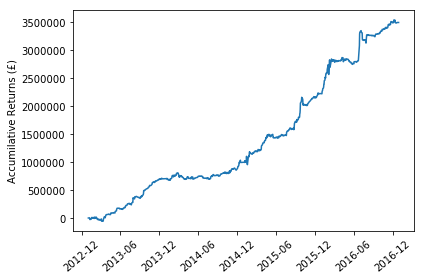

In [0]:
def JUMP_constraint(c2o, signalsdf, level):
    #level=JUMP_level
    temp=c2o.copy()

    temp=(temp-1)*100

    temp[temp>=level]=0
    temp[temp<=-level]=0

    temp=temp.fillna(0)
    temp[temp!=0]=1
    temp[temp==0]=np.nan
    #temp=temp[cols]
    template=signalsdf.copy()
    template=(template/template).fillna(1)
    temp_dates=template.copy()
    temp_dates['keep']=1
    temp_dates=temp_dates[['keep']]
    tempdf=signalsdf*temp
    tempdf=tempdf*template
    tempdf=pd.merge(tempdf, temp_dates, right_index=True, left_index=True, how='right').drop('keep', axis=1)
    tempdf=tempdf[signalsdf.columns]
    #tempdf=tempdf.dropna(how='all', axis=0)
    return tempdf

cond_signalsdf=JUMP_constraint(c2o, signalsdf, JUMP_level)
allinfodf,l_end, s_end, l_start, s_start=weighted_constrained_levels_fut(notional, notional_high, posmult, negmult, weights, tot_traded_fx, pos_liq_pcs, neg_liq_pcs, cond_signalsdf, impacted_o2c, indexdf)
allinfodf=allinfodf.reset_index()

tmpdf=allinfodf.copy()
tmpdf=tmpdf.set_index('index')
tmpdf=tmpdf[tmpdf.index<=datetime.date(2017,1,1)]
tmpdf=tmpdf[tmpdf.index>=datetime.date(2013,1,1)]
fig=plt.figure()
tmpdf['acc_raw_profit_hedged']=tmpdf['raw_profit_hedged'].cumsum()
plt.plot(tmpdf['acc_raw_profit_hedged'].dropna())

plt.ylabel('Accumilative Returns (£)')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('pnl_chart.jpg')

#plt.savefig('pnl_chart.pdf')
fig.show()
print('Sharpe:')
print((tmpdf['raw_profit_hedged'].dropna().mean()/tmpdf['raw_profit_hedged'].dropna().std())*16)

In [0]:
tmpdf.mean()

Count_Pos                  2.399707e+01
Count_Neg                  2.428098e+01
total_count                4.827805e+01
long_fixed                 2.500000e+05
short_fixed                2.500000e+05
high_long_fixed            2.500000e+05
high_short_fixed           2.500000e+05
Constrained_Count_Pos      1.944683e+01
Constrained_Count_Neg      2.031220e+01
Constrained_total_count    3.975902e+01
long_Day_end               7.478350e+05
short_Day_end             -1.110499e+06
long_Day_start             7.473265e+05
short_Day_start           -1.112376e+06
Diff_long                  5.085181e+02
Diff_short                 1.877160e+03
raw_profit                 2.385678e+03
acc_raw_profit             1.155279e+06
o2c_ba                    -1.383476e-04
o2c_ab                    -1.865053e-05
tot_invested               1.859703e+06
delta_Day_start            3.650498e+05
tot_invested_plus_hedge    2.897920e+06
hedge_sign                 1.414634e-01
delta_Day_end              3.614305e+05


In [0]:
tmpdf

,Count_Pos,Count_Neg,total_count,long_fixed,short_fixed,high_long_fixed,high_short_fixed,Constrained_Count_Pos,Constrained_Count_Neg,Constrained_total_count,...,diff_hedge,raw_profit_hedged,acc_raw_profit_hedged,hedge_ret,returns,ret_per_short_trade,ret_per_long_trade,SXXP Index,returns_detrend,ratio_pos_neg
index,,,,,,,,,,,,,,,,,,,,,
2013-01-02,2,2,4,250000,250000,250000,250000,0,2,2,...,93.810613,143.791601,1.437916e+02,0.004974,0.003458,1.000500,1.000000,0.006490,-0.003032,1.000000
2013-01-03,10,11,21,250000,250000,250000,250000,9,6,15,...,452.430017,953.964507,1.097756e+03,0.002609,0.002016,1.000564,1.000383,0.003873,-0.001858,0.916667
2013-01-04,12,11,23,250000,250000,250000,250000,10,9,19,...,-1866.852893,2196.234940,3.293991e+03,0.001414,0.003132,0.998429,1.008212,0.007292,-0.004160,1.083333
2013-01-07,26,21,47,250000,250000,250000,250000,19,14,33,...,211.812746,1882.729816,5.176721e+03,0.003448,0.003558,1.000932,1.000532,-0.002774,0.006331,1.227273
2013-01-08,13,25,38,250000,250000,250000,250000,9,15,24,...,-325.620665,-1049.435709,4.127285e+03,-0.000615,-0.000699,0.999537,0.999777,-0.000485,-0.000214,0.538462
2013-01-09,24,30,54,250000,250000,250000,250000,13,23,36,...,-470.042377,-28670.971458,-2.454369e+04,-0.012703,-0.013076,0.986289,0.993638,0.004685,-0.017761,0.806452
2013-01-10,28,26,54,250000,250000,250000,250000,20,19,39,...,-241.214731,-1783.293033,-2.632698e+04,-0.000938,-0.001155,0.999823,0.999063,-0.000426,-0.000728,1.074074
2013-01-11,20,31,51,250000,250000,250000,250000,9,23,32,...,-68.260344,7779.079589,-1.854790e+04,0.002193,0.004154,1.005733,0.998961,-0.000041,0.004195,0.656250
2013-01-14,37,38,75,250000,250000,250000,250000,28,34,62,...,-4667.432741,-2966.369445,-2.151427e+04,-0.000665,0.000564,1.003362,0.997467,-0.003230,0.003795,0.974359


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Sharpe:
3.914125722679248


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


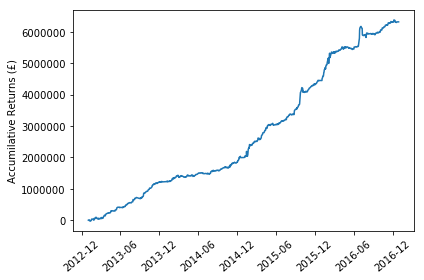

In [0]:
pos_pcs=neg_liq_pcs.copy()
neg_pcs=pos_liq_pcs.copy()

def JUMP_constraint(c2o, signalsdf, level):
    #level=JUMP_level
    temp=c2o.copy()

    temp=(temp-1)*100

    temp[temp>=level]=0
    temp[temp<=-level]=0

    temp=temp.fillna(0)
    temp[temp!=0]=1
    temp[temp==0]=np.nan
    #temp=temp[cols]
    template=signalsdf.copy()
    template=(template/template).fillna(1)
    temp_dates=template.copy()
    temp_dates['keep']=1
    temp_dates=temp_dates[['keep']]
    tempdf=signalsdf*temp
    tempdf=tempdf*template
    tempdf=pd.merge(tempdf, temp_dates, right_index=True, left_index=True, how='right').drop('keep', axis=1)
    tempdf=tempdf[signalsdf.columns]
    #tempdf=tempdf.dropna(how='all', axis=0)
    return tempdf

cond_signalsdf=JUMP_constraint(c2o, signalsdf, JUMP_level)
allinfodf,l_end, s_end, l_start, s_start=weighted_constrained_levels_fut(notional, notional_high, posmult, negmult, weights, tot_traded_fx, pos_pcs, neg_pcs, cond_signalsdf, o2c, indexdf)
allinfodf=allinfodf.reset_index()

tmpdf=allinfodf.copy()
tmpdf=tmpdf.set_index('index')
tmpdf=tmpdf[tmpdf.index<=datetime.date(2017,1,1)]
tmpdf=tmpdf[tmpdf.index>=datetime.date(2013,1,1)]
fig=plt.figure()
tmpdf['acc_raw_profit_hedged']=tmpdf['raw_profit_hedged'].cumsum()
plt.plot(tmpdf['acc_raw_profit_hedged'].dropna())

plt.ylabel('Accumilative Returns (£)')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('pnl_chart.jpg')
#plt.savefig('pnl_chart.pdf')
fig.show()
print('Sharpe:')
print((tmpdf['raw_profit_hedged'].dropna().mean()/tmpdf['raw_profit_hedged'].dropna().std())*16)

In [0]:
tmpdf.mean()

Count_Pos                  2.399707e+01
Count_Neg                  2.428098e+01
total_count                4.827805e+01
long_fixed                 2.500000e+05
short_fixed                2.500000e+05
high_long_fixed            2.500000e+05
high_short_fixed           2.500000e+05
Constrained_Count_Pos      1.521854e+01
Constrained_Count_Neg      1.592390e+01
Constrained_total_count    3.114244e+01
long_Day_end               1.264899e+06
short_Day_end             -1.654318e+06
long_Day_start             1.263378e+06
short_Day_start           -1.657821e+06
Diff_long                  1.521269e+03
Diff_short                 3.503542e+03
raw_profit                 5.024810e+03
acc_raw_profit             2.856870e+06
o2c_ba                    -1.703508e-04
o2c_ab                     4.588289e-06
tot_invested               2.921199e+06
delta_Day_start            3.944436e+05
tot_invested_plus_hedge    4.290698e+06
hedge_sign                 1.131707e-01
delta_Day_end              3.915654e+05


In [0]:
tmpdf

,Count_Pos,Count_Neg,total_count,long_fixed,short_fixed,high_long_fixed,high_short_fixed,Constrained_Count_Pos,Constrained_Count_Neg,Constrained_total_count,...,diff_hedge,raw_profit_hedged,acc_raw_profit_hedged,hedge_ret,returns,ret_per_short_trade,ret_per_long_trade,SXXP Index,returns_detrend,ratio_pos_neg
index,,,,,,,,,,,,,,,,,,,,,
2013-01-02,2,2,4,250000,250000,250000,250000,0,2,2,...,224.654614,606.687811,6.066878e+02,0.008764,0.011037,1.003820,1.000000,0.006490,0.004547,1.000000
2013-01-03,10,11,21,250000,250000,250000,250000,6,6,12,...,1689.164757,3774.501064,4.381189e+03,0.003744,0.003646,1.002844,1.001042,0.003873,-0.000227,0.916667
2013-01-04,12,11,23,250000,250000,250000,250000,9,6,15,...,-3853.377037,4950.992940,9.332182e+03,0.001778,0.003903,0.998314,1.016220,0.007292,-0.003389,1.083333
2013-01-07,26,21,47,250000,250000,250000,250000,13,8,21,...,616.503131,-644.955389,8.687226e+03,-0.000560,-0.001358,1.000867,0.998329,-0.002774,0.001415,1.227273
2013-01-08,13,25,38,250000,250000,250000,250000,8,7,15,...,-385.544444,-3868.365653,4.818861e+03,-0.001436,-0.001834,0.998614,0.997307,-0.000485,-0.001349,0.538462
2013-01-09,24,30,54,250000,250000,250000,250000,9,16,25,...,-3661.825995,-27158.771185,-2.233991e+04,-0.006689,-0.007167,0.986426,0.997387,0.004685,-0.011853,0.806452
2013-01-10,28,26,54,250000,250000,250000,250000,16,11,27,...,-147.021974,-7678.976014,-3.001889e+04,-0.002695,-0.003008,0.998836,0.995701,-0.000426,-0.002582,1.074074
2013-01-11,20,31,51,250000,250000,250000,250000,3,19,22,...,-89.148572,12663.576334,-1.735531e+04,0.002668,0.004943,1.009151,0.998568,-0.000041,0.004984,0.656250
2013-01-14,37,38,75,250000,250000,250000,250000,22,31,53,...,-6014.268369,-1683.915948,-1.903923e+04,-0.000205,0.000681,1.003723,0.998517,-0.003230,0.003912,0.974359


In [0]:
traded=(l_start)+abs(s_start)
pc_traded=traded/tot_traded_fx
pc_traded[pc_traded==0]=np.nan
traded_dfs=[]
pc_levs=[0.05, 0.1, 0.15]
for i in range(len(pc_levs)):
    j=pc_levs[i]
    if i>0:
        k=pc_levs[i-1]
    else:
        k=0
    if i<2:
        traded_dfs.append(pc_traded[(pc_traded<j) & (pc_traded>=k)])
    else:
        traded_dfs.append(pc_traded[(pc_traded>=k)])

temps=traded_dfs.copy()
for i in range(len(temps)):
    temps[i][temps[i]>0]=1
    temps[i]=temps[i]*impact_dfs[i]

#give the impACT ESTIMATES A SIGN
for i in range(len(temps)):
    temps[i]=temps[i]*signalsdf

impacts=pd.DataFrame()
for i in range(len(temps)):
    if i==0:
        impacts=temps[i].fillna(0)
    else:
        impacts=impacts+temps[i].fillna(0)
        
impacted_o2c=o2c-impacts

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Sharpe:
3.177326886975659


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


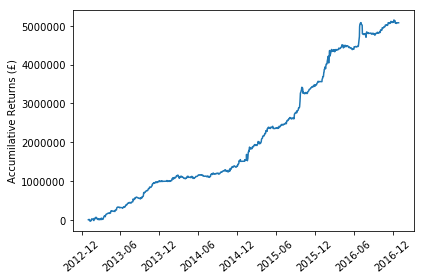

In [0]:
def JUMP_constraint(c2o, signalsdf, level):
    #level=JUMP_level
    temp=c2o.copy()

    temp=(temp-1)*100

    temp[temp>=level]=0
    temp[temp<=-level]=0

    temp=temp.fillna(0)
    temp[temp!=0]=1
    temp[temp==0]=np.nan
    #temp=temp[cols]
    template=signalsdf.copy()
    template=(template/template).fillna(1)
    temp_dates=template.copy()
    temp_dates['keep']=1
    temp_dates=temp_dates[['keep']]
    tempdf=signalsdf*temp
    tempdf=tempdf*template
    tempdf=pd.merge(tempdf, temp_dates, right_index=True, left_index=True, how='right').drop('keep', axis=1)
    tempdf=tempdf[signalsdf.columns]
    #tempdf=tempdf.dropna(how='all', axis=0)
    return tempdf

cond_signalsdf=JUMP_constraint(c2o, signalsdf, JUMP_level)
allinfodf,l_end, s_end, l_start, s_start=weighted_constrained_levels_fut(notional, notional_high, posmult, negmult, weights, tot_traded_fx, pos_pcs, neg_pcs, cond_signalsdf, impacted_o2c, indexdf)
allinfodf=allinfodf.reset_index()

tmpdf=allinfodf.copy()
tmpdf=tmpdf.set_index('index')
tmpdf=tmpdf[tmpdf.index<=datetime.date(2017,1,1)]
tmpdf=tmpdf[tmpdf.index>=datetime.date(2013,1,1)]
fig=plt.figure()
tmpdf['acc_raw_profit_hedged']=tmpdf['raw_profit_hedged'].cumsum()
plt.plot(tmpdf['acc_raw_profit_hedged'].dropna())

plt.ylabel('Accumilative Returns (£)')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('pnl_chart.jpg')
#plt.savefig('pnl_chart.pdf')
fig.show()
print('Sharpe:')
print((tmpdf['raw_profit_hedged'].dropna().mean()/tmpdf['raw_profit_hedged'].dropna().std())*16)

In [0]:
tmpdf.mean()

Count_Pos                  2.399707e+01
Count_Neg                  2.428098e+01
total_count                4.827805e+01
long_fixed                 2.500000e+05
short_fixed                2.500000e+05
high_long_fixed            2.500000e+05
high_short_fixed           2.500000e+05
Constrained_Count_Pos      1.521854e+01
Constrained_Count_Neg      1.592390e+01
Constrained_total_count    3.114244e+01
long_Day_end               1.264364e+06
short_Day_end             -1.655017e+06
long_Day_start             1.263378e+06
short_Day_start           -1.657821e+06
Diff_long                  9.861652e+02
Diff_short                 2.804142e+03
raw_profit                 3.790307e+03
acc_raw_profit             2.090149e+06
o2c_ba                    -1.703508e-04
o2c_ab                     4.588289e-06
tot_invested               2.921199e+06
delta_Day_start            3.944436e+05
tot_invested_plus_hedge    4.290698e+06
hedge_sign                 1.131707e-01
delta_Day_end              3.915654e+05


In [0]:
tmpdf#.mean()

,Count_Pos,Count_Neg,total_count,long_fixed,short_fixed,high_long_fixed,high_short_fixed,Constrained_Count_Pos,Constrained_Count_Neg,Constrained_total_count,...,diff_hedge,raw_profit_hedged,acc_raw_profit_hedged,hedge_ret,returns,ret_per_short_trade,ret_per_long_trade,SXXP Index,returns_detrend,ratio_pos_neg
index,,,,,,,,,,,,,,,,,,,,,
2013-01-02,2,2,4,250000,250000,250000,250000,0,2,2,...,224.654614,597.169018,5.971690e+02,0.008626,0.010762,1.003725,1.000000,0.006490,0.004272,1.000000
2013-01-03,10,11,21,250000,250000,250000,250000,6,6,12,...,1689.164757,3527.899784,4.125069e+03,0.003500,0.003215,1.002478,1.000952,0.003873,-0.000658,0.916667
2013-01-04,12,11,23,250000,250000,250000,250000,9,6,15,...,-3853.377037,4300.621855,8.425691e+03,0.001545,0.003615,0.997845,1.015565,0.007292,-0.003677,1.083333
2013-01-07,26,21,47,250000,250000,250000,250000,13,8,21,...,616.503131,-1118.270926,7.307420e+03,-0.000972,-0.001868,1.000659,0.998134,-0.002774,0.000905,1.227273
2013-01-08,13,25,38,250000,250000,250000,250000,8,7,15,...,-385.544444,-4539.895269,2.767524e+03,-0.001685,-0.002188,0.998273,0.996930,-0.000485,-0.001702,0.538462
2013-01-09,24,30,54,250000,250000,250000,250000,9,16,25,...,-3661.825995,-28786.273973,-2.601875e+04,-0.007090,-0.007663,0.986006,0.996556,0.004685,-0.012349,0.806452
2013-01-10,28,26,54,250000,250000,250000,250000,16,11,27,...,-147.021974,-8648.063404,-3.466681e+04,-0.003035,-0.003395,0.998384,0.995429,-0.000426,-0.002969,1.074074
2013-01-11,20,31,51,250000,250000,250000,250000,3,19,22,...,-89.148572,11320.205442,-2.334661e+04,0.002385,0.004422,1.008331,0.998497,-0.000041,0.004463,0.656250
2013-01-14,37,38,75,250000,250000,250000,250000,22,31,53,...,-6014.268369,-4229.165578,-2.757577e+04,-0.000515,0.000281,1.002920,0.997966,-0.003230,0.003511,0.974359


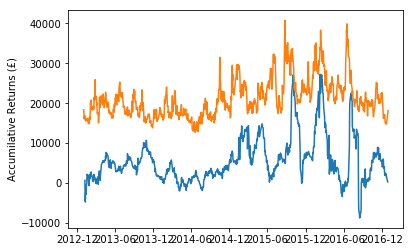

In [0]:
t=tmpdf.copy()
t=pd.merge(vix, tmpdf, right_index=True, left_index=True)
plt.plot(t['raw_profit_hedged'].dropna().rolling(window=30, min_periods=5).mean())
plt.plot(t['vix'].dropna()*1000)
plt.ylabel('Accumilative Returns (£)')
plt.show()

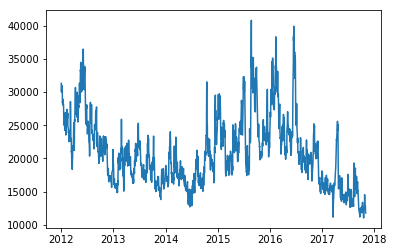

In [0]:
plt.plot(vix['vix'].dropna()*1000)
#plt.ylabel('Accumilative Returns (£)')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     334.1
Date:                Fri, 10 Nov 2017   Prob (F-statistic):           2.48e-64
Time:                        16:58:02   Log-Likelihood:                -9304.3
No. Observations:                 968   AIC:                         1.861e+04
Df Residuals:                     966   BIC:                         1.862e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2.523e+04   1686.093    -14.965      0.000     -2.85e+04 -2.19e+04
x1          1.016e+04    555.783     18.279      0.000      9068.282  1.12e+04
==============================================================================
Omnibus:                       14.317   Durbin-Watson:                   0.067
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.492
Skew:                           0.282   Prob(JB):                     0.000713
Kurtosis:                       2.799   Cond. No.                         48.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

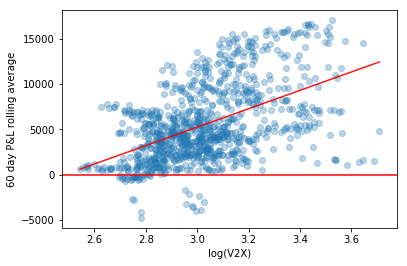

In [0]:
t=tmpdf.copy()
t=pd.merge(vix, t, right_index=True, left_index=True)
t['mavg']=t['raw_profit_hedged'].dropna().rolling(window=60, min_periods=5).mean()

t=t.dropna()
#np.corrcoef(t['hedge_ret'],t['c2o'])

import statsmodels.api as sm
from statsmodels import regression
def linreg(X,Y):

    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('log(V2X)')
    plt.ylabel('60 day P&L rolling average')
    plt.axhline(0, color='red')
    plt.savefig('v2x_PNL.jpg')
    return model.summary()

#t=temp[temp['PC_case']==6]
t=t[['mavg','vix', 'raw_profit_hedged']].dropna()
#t=t[abs(t['PC'])<100]
linreg( np.log(t['vix'].astype(float).values), t['mavg'].astype(float).values)

In [0]:
weights_info[['ret', 'sentiment', 'momentum', 'vol', 'size', 'c2o']]

,ret,sentiment,momentum,vol,size,c2o
0,-4.578497,10.000000,4.372628,2.0,5.0,-2.888046
1,-6.880829,-10.000000,-33.811323,-3.0,5.0,-2.807503
2,0.654646,-10.000000,-3.941076,-1.0,5.0,-2.861703
3,-0.751215,5.860168,6.230266,1.0,5.0,-2.186346
4,-2.600633,-8.190220,-8.868824,-2.0,1.0,-0.902217
5,-2.393051,-10.000000,-2.257389,-1.0,5.0,-2.674829
6,-3.168692,10.000000,16.361872,2.0,5.0,-1.053217
7,-3.965462,10.000000,-7.206176,2.0,5.0,-2.542537
8,-0.256629,-7.147600,-2.012026,-1.0,5.0,-2.357728
9,-1.872615,-7.697174,-21.673462,-3.0,5.0,-3.904710


In [0]:
t=tmpdf.copy()
t=pd.merge(vix, t, right_index=True, left_index=True)
t['mavg']=t['raw_profit_hedged'].dropna().rolling(window=30, min_periods=5).mean()

t=t.dropna()
t

,vix,Count_Pos,Count_Neg,total_count,long_fixed,short_fixed,high_long_fixed,high_short_fixed,Constrained_Count_Pos,Constrained_Count_Neg,...,raw_profit_hedged,acc_raw_profit_hedged,hedge_ret,returns,ret_per_short_trade,ret_per_long_trade,SXXP Index,returns_detrend,ratio_pos_neg,mavg
2013-01-08,16.8999,9,25,34,250000,250000,250000,250000,6,15,...,-25.852443,4.504111e+03,-1.515148e-05,0.000362,0.999679,1.001654,-0.000485,0.000847,0.384615,900.822280
2013-01-09,16.1474,23,28,51,250000,250000,250000,250000,12,21,...,-25503.299598,-2.099919e+04,-1.139483e-02,-0.012254,0.988091,0.993356,0.004685,-0.016939,0.827586,-3499.864700
2013-01-10,16.1155,26,25,51,250000,250000,250000,250000,20,18,...,-1545.806139,-2.254499e+04,-8.356580e-04,-0.001005,0.999924,0.999061,-0.000426,-0.000579,1.038462,-3220.713477
2013-01-11,15.5715,18,29,47,250000,250000,250000,250000,8,21,...,7253.879757,-1.529111e+04,2.194933e-03,0.004201,1.005348,0.999515,-0.000041,0.004242,0.633333,-1911.389323
2013-01-14,15.7019,36,35,71,250000,250000,250000,250000,28,31,...,-4455.306875,-1.974642e+04,-1.151254e-03,-0.000273,1.002168,0.997481,-0.003230,0.002958,1.027778,-2194.046829
2013-01-15,15.9725,33,20,53,250000,250000,250000,250000,28,11,...,14124.033979,-5.622387e+03,2.508809e-03,0.006249,1.014137,1.003825,0.002682,0.003567,1.619048,-562.238748
2013-01-16,16.146,24,23,47,250000,250000,250000,250000,18,17,...,1327.500759,-4.294887e+03,9.197272e-04,0.001157,0.997555,1.003564,0.000784,0.000374,1.041667,-390.444247
2013-01-17,15.9134,20,12,32,250000,250000,250000,250000,14,8,...,313.266021,-3.981621e+03,7.226962e-04,0.001615,0.998350,1.001603,0.005598,-0.003984,1.615385,-331.801725
2013-01-18,15.8831,20,19,39,250000,250000,250000,250000,13,15,...,18269.032977,1.428741e+04,6.346925e-03,0.009245,1.012492,1.003218,0.002554,0.006691,1.050000,1099.031714
2013-01-21,15.4605,25,23,48,250000,250000,250000,250000,18,14,...,3151.879570,1.743929e+04,2.873465e-03,0.003125,0.997030,1.005305,0.000937,0.002188,1.083333,1245.663703


Consumer Discretionary


C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Sharpe:
1.8560932280530387
Consumer Staples
Sharpe:
1.4038484930071964
Energy
Sharpe:
0.8392187088769417
Financials
Sharpe:
1.1697083868150437
Health Care
Sharpe:
1.9704820914129928
Industrials
Sharpe:
1.028071236114413
Information Technology
Sharpe:
0.7059976528742482
Materials
Sharpe:
1.4489575942930866
Real Estate
Sharpe:
0.20595154646603048
Telecommunication Services
Sharpe:
0.017549910192105864
Utilities
Sharpe:
0.9264676818517875


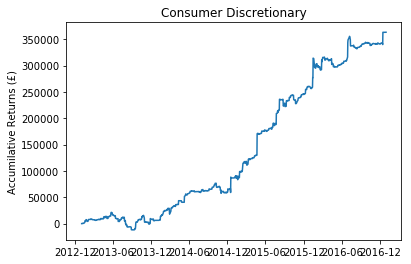

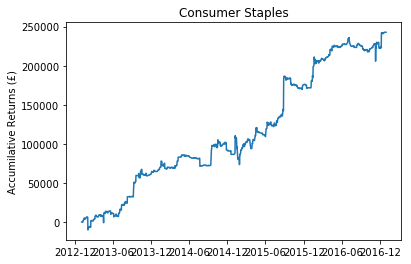

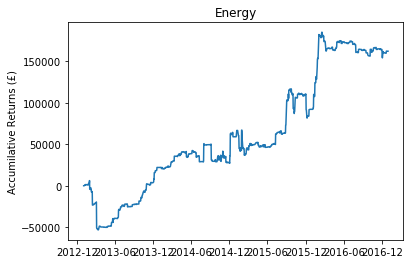

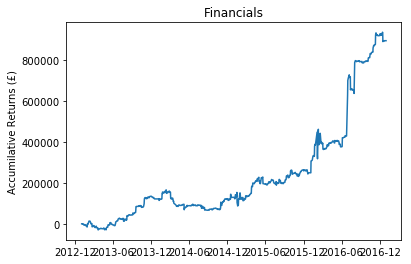

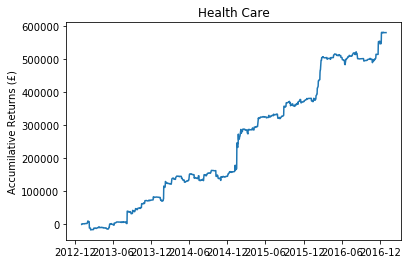

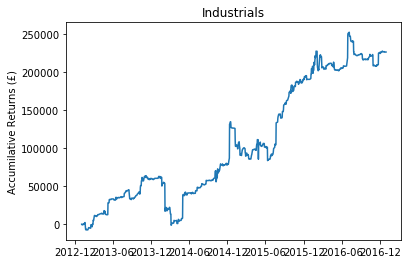

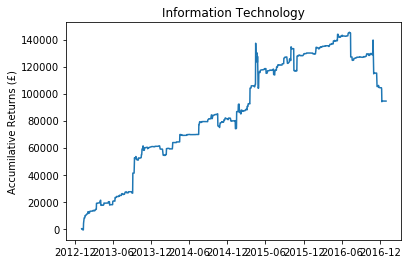

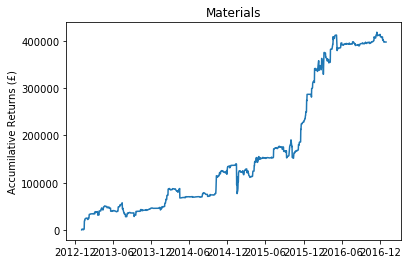

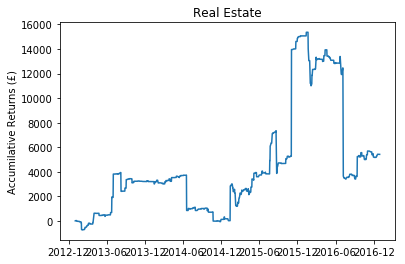

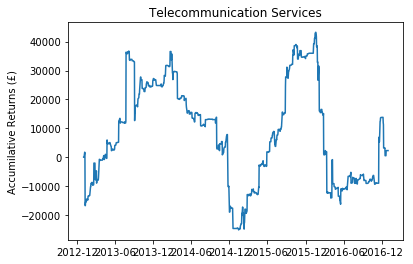

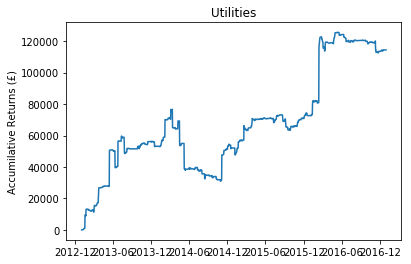

In [0]:
def JUMP_constraint(c2o, signalsdf, level):
    #level=JUMP_level
    temp=c2o.copy()

    temp=(temp-1)*100

    temp[temp>=level]=0
    temp[temp<=-level]=0

    temp=temp.fillna(0)
    temp[temp!=0]=1
    temp[temp==0]=np.nan
    #temp=temp[cols]
    template=signalsdf.copy()
    template=(template/template).fillna(1)
    temp_dates=template.copy()
    temp_dates['keep']=1
    temp_dates=temp_dates[['keep']]
    tempdf=signalsdf*temp
    tempdf=tempdf*template
    tempdf=pd.merge(tempdf, temp_dates, right_index=True, left_index=True, how='right').drop('keep', axis=1)
    tempdf=tempdf[signalsdf.columns]
    #tempdf=tempdf.dropna(how='all', axis=0)
    return tempdf


for S in s:
    print(S)
    ticks=sectors[sectors['sector']==S]
    ticks['Name']=ticks['Name']+' Equity'
    names=ticks['Name'].unique().tolist()
    n=list(set(signalsdf.columns.tolist())&set(names))
    ts=signalsdf[n]

    cond_signalsdf=JUMP_constraint(c2o, ts, JUMP_level)
    allinfodf,l_end, s_end, l_start, s_start=weighted_constrained_levels_fut(notional, notional_high, posmult, negmult, weights, tot_traded_fx, pos_liq_pcs, neg_liq_pcs, cond_signalsdf, o2c, indexdf)
    allinfodf=allinfodf.reset_index()

    tmpdf=allinfodf.copy()
    tmpdf=tmpdf.set_index('index')
    tmpdf=tmpdf[tmpdf.index<=datetime.date(2017,1,1)]
    tmpdf=tmpdf[tmpdf.index>=datetime.date(2013,1,1)]
    fig=plt.figure()
    tmpdf['acc_raw_profit']=tmpdf['raw_profit'].cumsum()

    plt.plot(tmpdf['acc_raw_profit'].dropna())

    plt.title(S)
    plt.ylabel('Accumilative Returns (£)')

    #plt.savefig('pnl_chart.pdf')
    fig.show()
    print('Sharpe:')
    print((tmpdf['raw_profit'].dropna().mean()/tmpdf['raw_profit'].dropna().std())*16)

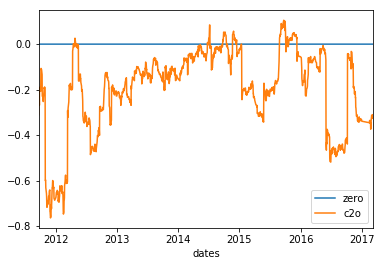

In [0]:
temp=betadf.set_index('dates')
temp['zero']=0
temp['zero'].plot()
temp['c2o'].plot()
plt.legend()
plt.show()

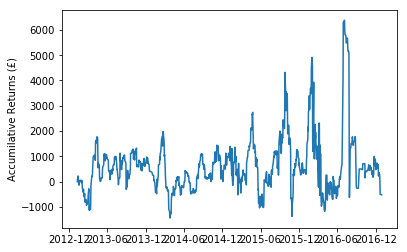

In [0]:
t=tmpdf.copy()
t=pd.merge(vix, tmpdf, right_index=True, left_index=True)
plt.plot(t['raw_profit_hedged'].dropna().rolling(window=20, min_periods=5).mean())
#plt.plot(t['vix'].dropna()*500)
plt.ylabel('Accumilative Returns (£)')
plt.show()

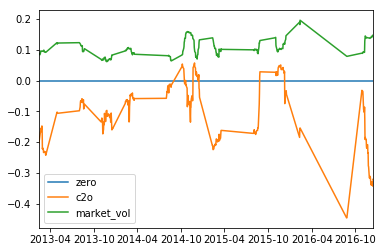

In [0]:
tmpdf['market_vol']=(tmpdf['SXXP Index'].rolling(window=30).std())*np.sqrt(252)

temp=betadf.set_index('dates')
temp['zero']=0
temp['c2o_ave']=temp['c2o'].rolling(window=30).mean()
t=pd.merge(temp, tmpdf, right_index=True, left_index=True)
t=t[['c2o', 'market_vol', 'raw_profit_hedged']].dropna()

t['zero']=0
t['zero'].plot()
t['c2o'].plot()
t['market_vol'].plot()
plt.legend()
plt.show()


In [0]:
np.corrcoef(t['market_vol'],t['raw_profit_hedged'])


array([[ 1.        , -0.02880539],
       [-0.02880539,  1.        ]])

C:\Users\john.geary\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


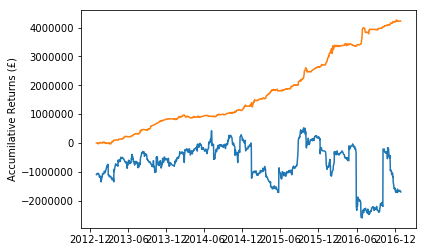

In [0]:
t=pd.merge(tmpdf, temp, right_index=True, left_index=True)
plt.plot(t['c2o']*5000000)
plt.plot(t['acc_raw_profit_hedged'].dropna())


plt.ylabel('Accumilative Returns (£)')

#plt.savefig('pnl_chart.pdf')
fig.show()
